## Dataset Overview

This dataset merges weekly Walmart sales with external features across 45 stores and 99 departments from Feb 2010 to Oct/Nov 2012 (~143 weeks). There are ~421,570 training records and ~115,064 test records.


| Column Name     | Data Type       | Description                                                                 |
|-----------------|----------------|-----------------------------------------------------------------------------|
| **Date**        | `YYYY-MM-DD`   | The week-ending date for each sales observation.                           |
| **IsHoliday**   | `0 or 1`       | Indicates if the week included a major holiday.                            |
| **Dept**        | Integer        | Department number (1–99).                                                  |
| **Weekly_Sales**| Numeric (float)| Total sales (USD) for the department during that week.                     |
| **Temperature** | Numeric (°F)   | Average regional temperature for the week.                                 |
| **Fuel_Price**  | Numeric (USD/gal)| Average weekly fuel price in the region.                                 |
| **CPI**         | Numeric        | Consumer Price Index—a weekly macroeconomic indicator.                     |
| **Unemployment**| Numeric (%)    | Regional weekly unemployment rate.                                         |


Dept 18 = Seasonal

- According to multiple sources (including internal Walmart docs and staff references), **Department 18** is officially labeled **_Seasonal_**, covering items like holiday decorations, party supplies, gift wrap, greeting cards, and seasonal decor (Christmas, Halloween, Easter, etc.)


## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')


In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
import itertools
import time


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [5]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully!")

TensorFlow version: 2.18.0
Libraries imported successfully!


In [8]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset & Convert Date Column

In [80]:
df = pd.read_csv('project_dataset.csv')

df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,0,1.0,24924.50,42.31,2.572,211.096358,8.106
1,2010-02-05,0,26.0,11737.12,42.31,2.572,211.096358,8.106
2,2010-02-05,0,17.0,13223.76,42.31,2.572,211.096358,8.106
3,2010-02-05,0,45.0,37.44,42.31,2.572,211.096358,8.106
4,2010-02-05,0,28.0,1085.29,42.31,2.572,211.096358,8.106


In [81]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")

# Set the 'Date' column as the index
df.set_index('Date', inplace = True)

df.head()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,0,1.0,24924.50,42.31,2.572,211.096358,8.106
2010-02-05,0,26.0,11737.12,42.31,2.572,211.096358,8.106
2010-02-05,0,17.0,13223.76,42.31,2.572,211.096358,8.106
2010-02-05,0,45.0,37.44,42.31,2.572,211.096358,8.106
2010-02-05,0,28.0,1085.29,42.31,2.572,211.096358,8.106


In [82]:
dept18_df = df[df['Dept'] == 18].sort_index()

dept18_df.head()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,0,18.0,4729.50,42.31,2.572,211.096358,8.106
2010-02-12,1,18.0,19006.50,38.51,2.548,211.242170,8.106
2010-02-19,0,18.0,17623.72,39.93,2.514,211.289143,8.106
2010-02-26,0,18.0,545.02,46.63,2.561,211.319643,8.106
2010-03-05,0,18.0,634.61,46.50,2.625,211.350143,8.106


## Data Exploration & Visualization

In [9]:
print("Dataset contains", dept18_df.shape[0], "rows and", dept18_df.shape[1], "columns.")

Dataset contains 113 rows and 7 columns.


In [ ]:
print(f"Date Range: {dept18_df.index.min()} to {dept18_df.index.max()}")
print(f"Total Weeks: {len(dept18_df)}")


Date Range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Total Weeks: 113


In [ ]:
# Check for missing values
print("Missing values:\n", dept18_df.isnull().sum())

Missing values:
 IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [ ]:
# Summary statistics
dept18_df.describe()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,113.000000,113.0,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.088496,18.0,7765.304425,64.565133,3.238832,216.134174,7.616681
std,0.285279,0.0,11435.692635,13.493804,0.427576,4.286761,0.382212
min,0.000000,18.0,-1.270000,35.400000,2.514000,210.337426,6.573000
25%,0.000000,18.0,132.000000,54.110000,2.795000,211.671989,7.348000
50%,0.000000,18.0,2303.360000,65.930000,3.297000,215.627954,7.742000
75%,0.000000,18.0,10569.090000,75.640000,3.601000,220.265178,7.866000
max,1.000000,18.0,53845.120000,88.540000,3.907000,223.444251,8.106000


Insights:

The mean Weekly Sales is $7,765, while the median is only $2,303, indicating a right-skewed distribution.

The sales values range from -$1.27 to $53,845, showing very high variability.

The standard deviation is high, suggesting the presence of significant outliers or sales spikes.

In [ ]:
# TARGET VARIABLE ANALYSIS (Weekly_Sales)
print("\nWEEKLY SALES ANALYSIS")
print("-" * 40)
print(f"Mean Weekly Sales: ${dept18_df['Weekly_Sales'].mean():,.2f}")
print(f"Median Weekly Sales: ${dept18_df['Weekly_Sales'].median():,.2f}")
print(f"Standard Deviation: ${dept18_df['Weekly_Sales'].std():,.2f}")
print(f"Min Sales: ${dept18_df['Weekly_Sales'].min():,.2f}")
print(f"Max Sales: ${dept18_df['Weekly_Sales'].max():,.2f}")


WEEKLY SALES ANALYSIS
----------------------------------------
Mean Weekly Sales: $7,765.30
Median Weekly Sales: $2,303.36
Standard Deviation: $11,435.69
Min Sales: $-1.27
Max Sales: $53,845.12


Insights:

The sales distribution has a large gap between mean and median, confirming the presence of outliers or occasional high sales peaks.

Minimum value is negative, which may represent returns or refunds.

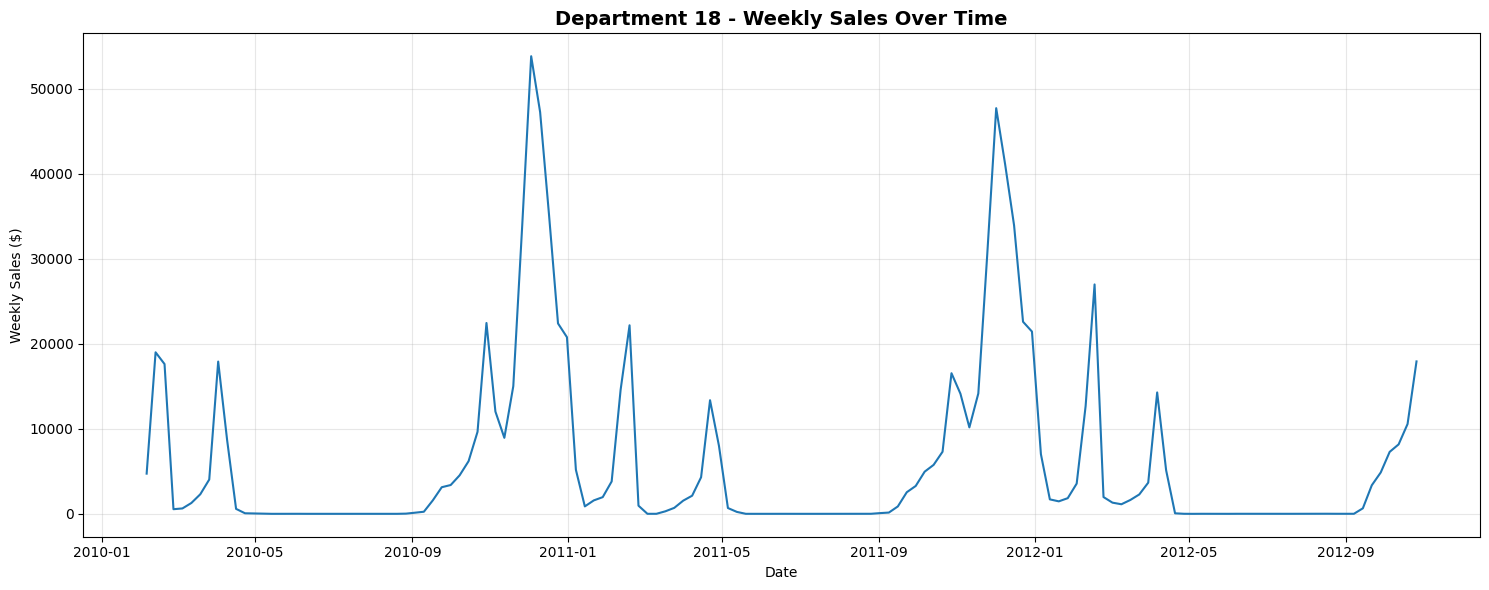

In [ ]:
# Time Series Plot
plt.figure(figsize=(15, 6))
plt.plot(dept18_df.index, dept18_df['Weekly_Sales'], linewidth=1.5)
plt.title('Department 18 - Weekly Sales Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Weekly Sales ($)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Insights:

Sales exhibit sharp peaks during specific weeks, likely tied to holidays or promotions.

There is no obvious long-term trend, but seasonal patterns appear to repeat annually.

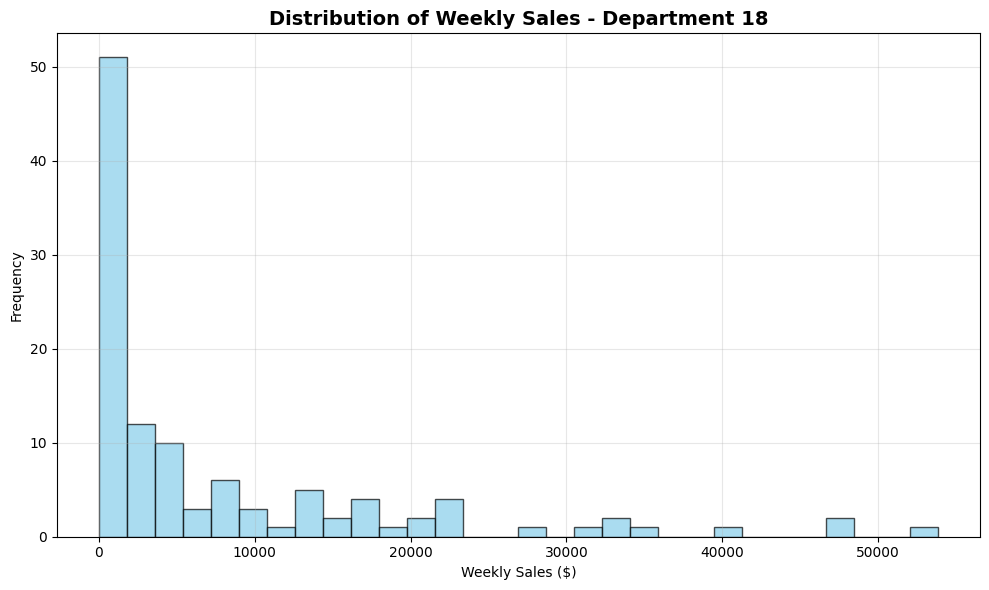

Normality test p-value: 0.000000
Sales distribution is not normal


In [ ]:
# Sales Distribution
plt.figure(figsize=(10, 6))
plt.hist(dept18_df['Weekly_Sales'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Weekly Sales - Department 18', fontsize=14, fontweight='bold')
plt.xlabel('Weekly Sales ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check if distribution is normal
from scipy.stats import normaltest
stat, p_value = normaltest(dept18_df['Weekly_Sales'])
print(f"Normality test p-value: {p_value:.6f}")
if p_value > 0.05:
    print("Sales distribution appears to be normal")
else:
    print("Sales distribution is not normal")

Insights:

The distribution of weekly sales is heavily right-skewed with many low values and a few extremely high ones.

Normality test p-value = 0.000000, so the distribution is not normal.

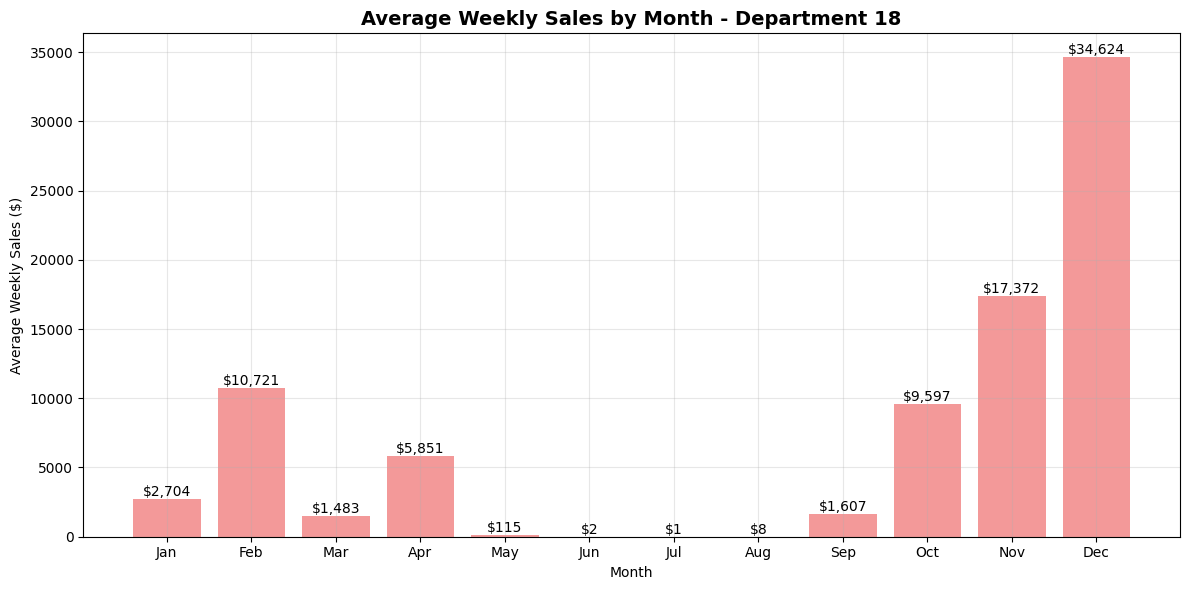

Monthly Sales Summary:
  Jan: $2,703.76
  Feb: $10,721.45
  Mar: $1,482.66
  Apr: $5,851.12
  May: $114.71
  Jun: $2.07
  Jul: $1.24
  Aug: $8.15
  Sep: $1,607.45
  Oct: $9,596.68
  Nov: $17,371.51
  Dec: $34,624.44


In [ ]:
# Monthly Seasonal Analysis
dept18_df['Month'] = dept18_df.index.month
monthly_sales = dept18_df.groupby('Month')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_sales.index, monthly_sales.values, color='lightcoral', alpha=0.8)
plt.title('Average Weekly Sales by Month - Department 18', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales ($)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Monthly Sales Summary:")
for month, sales in monthly_sales.items():
    month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][month-1]
    print(f"  {month_name}: ${sales:,.2f}")

Insights:

December has the highest average sales (~$34,624), followed by November and February.

Sales are lowest in summer months (June, July, August), indicating possible seasonal slowdown.

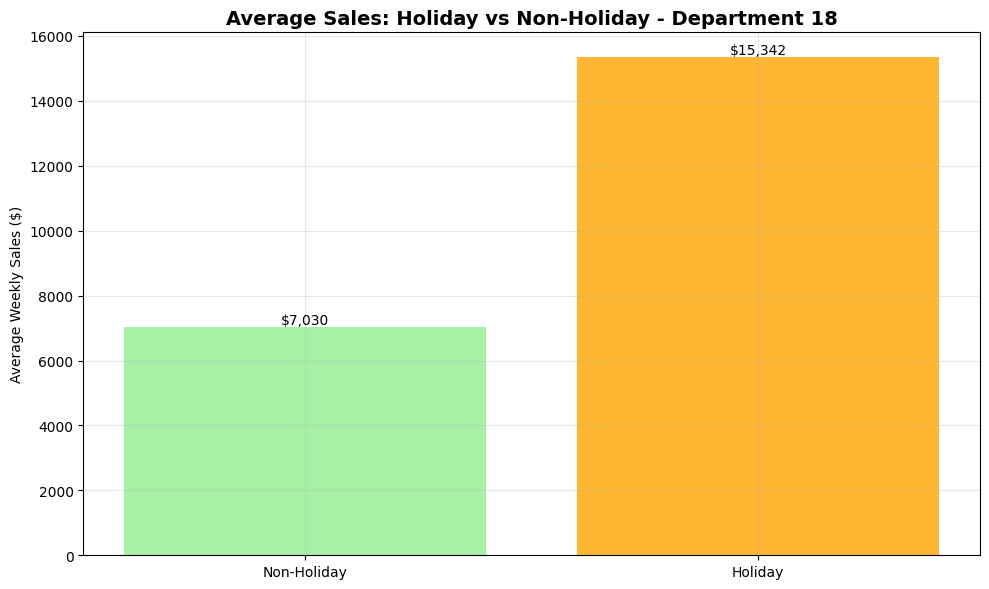

Holiday Effect Analysis:
                   mean  count           std
IsHoliday                                   
0           7029.701068    103  11139.580713
1          15342.019000     10  12291.823972

Holiday sales are 118.25% higher than non-holiday sales


In [ ]:
# Holiday Effect Analysis
holiday_effect = dept18_df.groupby('IsHoliday')['Weekly_Sales'].agg(['mean', 'count', 'std'])

plt.figure(figsize=(10, 6))
bars = plt.bar(['Non-Holiday', 'Holiday'], holiday_effect['mean'].values,
               color=['lightgreen', 'orange'], alpha=0.8)
plt.title('Average Sales: Holiday vs Non-Holiday - Department 18', fontsize=14, fontweight='bold')
plt.ylabel('Average Weekly Sales ($)')
plt.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Holiday Effect Analysis:")
print(holiday_effect)

# Calculate percentage difference
pct_diff = ((holiday_effect['mean'].iloc[1] - holiday_effect['mean'].iloc[0]) /
            holiday_effect['mean'].iloc[0]) * 100
print(f"\nHoliday sales are {pct_diff:.2f}% {'higher' if pct_diff > 0 else 'lower'} than non-holiday sales")

Insights:

Average weekly sales during holidays are ~$15,342, compared to ~$7,030 for non-holidays.

This means sales during holiday weeks are ~118% higher.

Holidays have a significant positive effect on Department 18 sales.

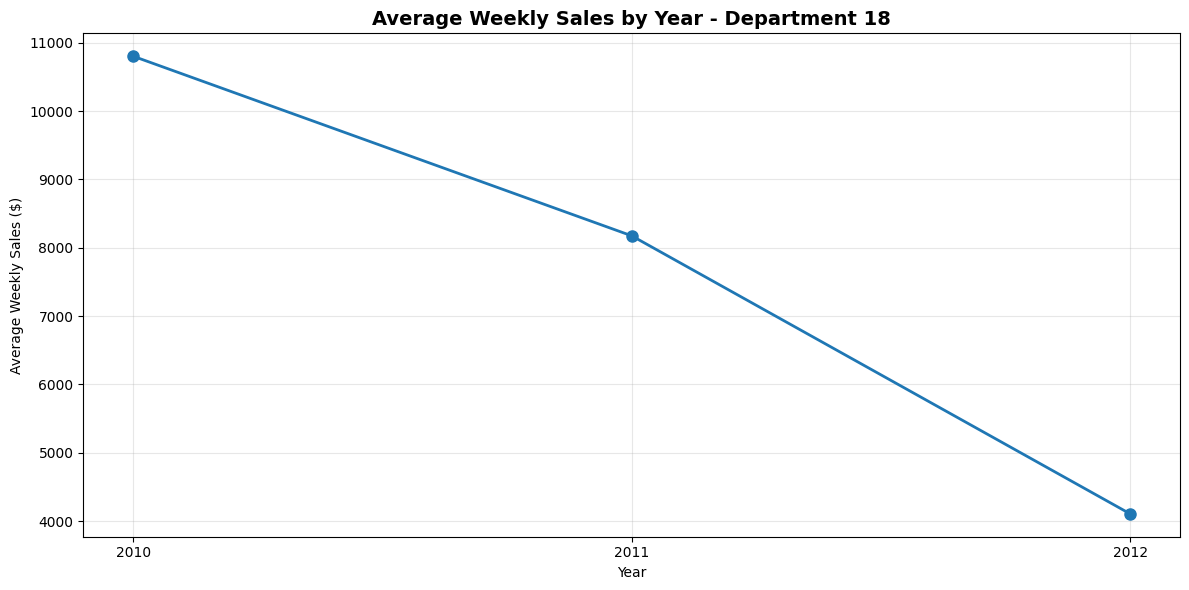

Year-over-Year Growth:
  2011: -24.32%
  2012: -49.77%


In [ ]:
# Yearly Trend Analysis
dept18_df['Year'] = dept18_df.index.year
yearly_sales = dept18_df.groupby('Year')['Weekly_Sales'].agg(['mean', 'count', 'std'])

plt.figure(figsize=(12, 6))
plt.plot(yearly_sales.index, yearly_sales['mean'].values, marker='o', linewidth=2, markersize=8)
plt.title('Average Weekly Sales by Year - Department 18', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Weekly Sales ($)')
plt.grid(True, alpha=0.3)
plt.xticks(yearly_sales.index)
plt.tight_layout()
plt.show()

# Calculate year-over-year growth
yoy_growth = yearly_sales['mean'].pct_change() * 100
print("Year-over-Year Growth:")
for year, growth in yoy_growth.items():
    if not np.isnan(growth):
        print(f"  {year}: {growth:.2f}%")

Insights:

There is a downward trend in average sales over time.

   - Sales in 2011 dropped by ~24%, and in 2012 dropped by ~50% compared to 2010.

This could be due to external market factors or internal store changes.

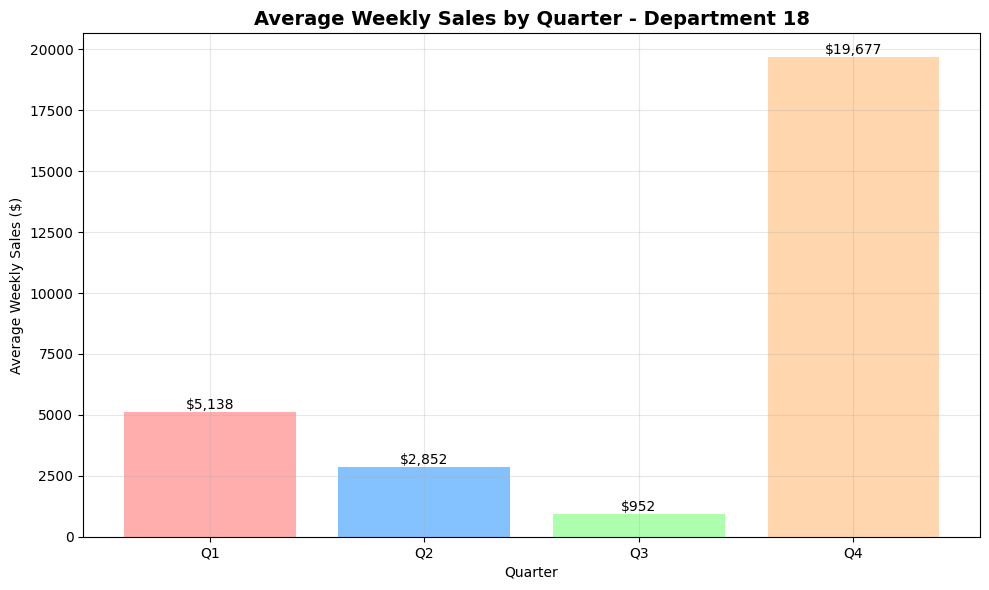


Average Sales by Quarter:
  Q1: $5,138.24
  Q2: $2,851.65
  Q3: $952.25
  Q4: $19,676.56


In [ ]:
# Quarterly Seasonality
dept18_df['Quarter'] = dept18_df.index.quarter
quarterly_pattern = dept18_df.groupby('Quarter')['Weekly_Sales'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_pattern.values,
               color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'], alpha=0.8)
plt.title('Average Weekly Sales by Quarter - Department 18', fontsize=14, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average Weekly Sales ($)')
plt.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nAverage Sales by Quarter:")
for quarter, sales in quarterly_pattern.items():
    print(f"  Q{quarter}: ${sales:,.2f}")


Insights:

Q4 (Oct–Dec) has the highest average sales (~$19,677), supporting the holiday boost hypothesis.

Q3 (Jul–Sep) has the lowest average sales (~$952), showing seasonal decline in summer.

Correlation between Weekly_Sales and Temperature: -0.4785
Correlation between Weekly_Sales and Fuel_Price: -0.2560
Correlation between Weekly_Sales and CPI: -0.0892
Correlation between Weekly_Sales and Unemployment: 0.1938


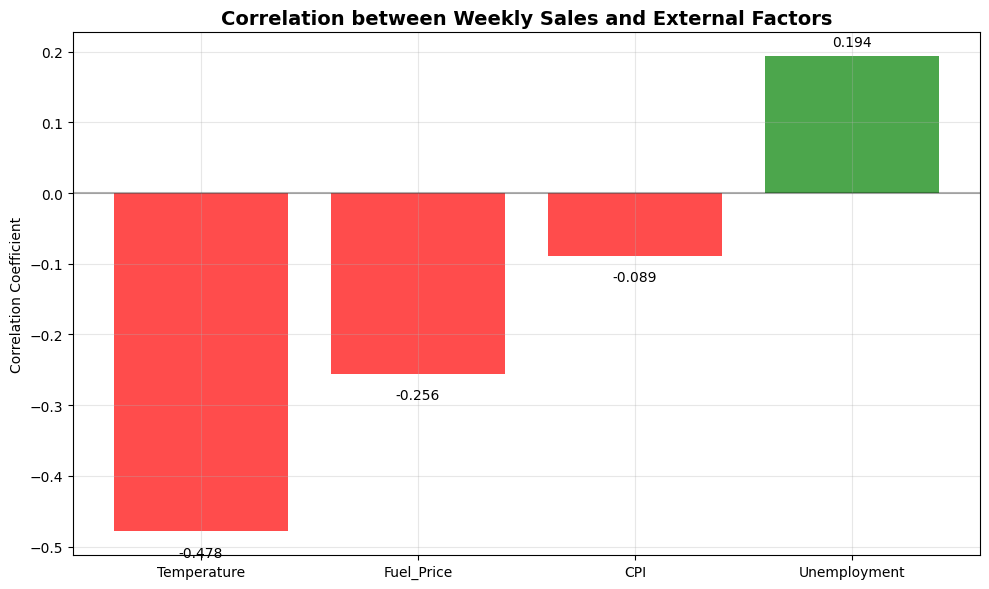

In [ ]:
# External Factors Correlation
external_vars = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
correlations = []
for var in external_vars:
    corr = dept18_df['Weekly_Sales'].corr(dept18_df[var])
    correlations.append(corr)
    print(f"Correlation between Weekly_Sales and {var}: {corr:.4f}")

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in correlations]
bars = plt.bar(external_vars, correlations, color=colors, alpha=0.7)
plt.title('Correlation between Weekly Sales and External Factors', fontsize=14, fontweight='bold')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.02),
             f'{height:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()


Insights:

When the temperature increases, sales tend to decrease.

When fuel prices go up, sales also decrease a little.

The CPI (which shows the average price of goods) doesn’t really affect sales much.

When unemployment is a bit higher, sales slightly increase, maybe because more people shop at Walmart when they don’t have jobs.

SEASONAL DECOMPOSITION ANALYSIS
Multiplicative decomposition failed: Multiplicative seasonality is not appropriate for zero and negative values


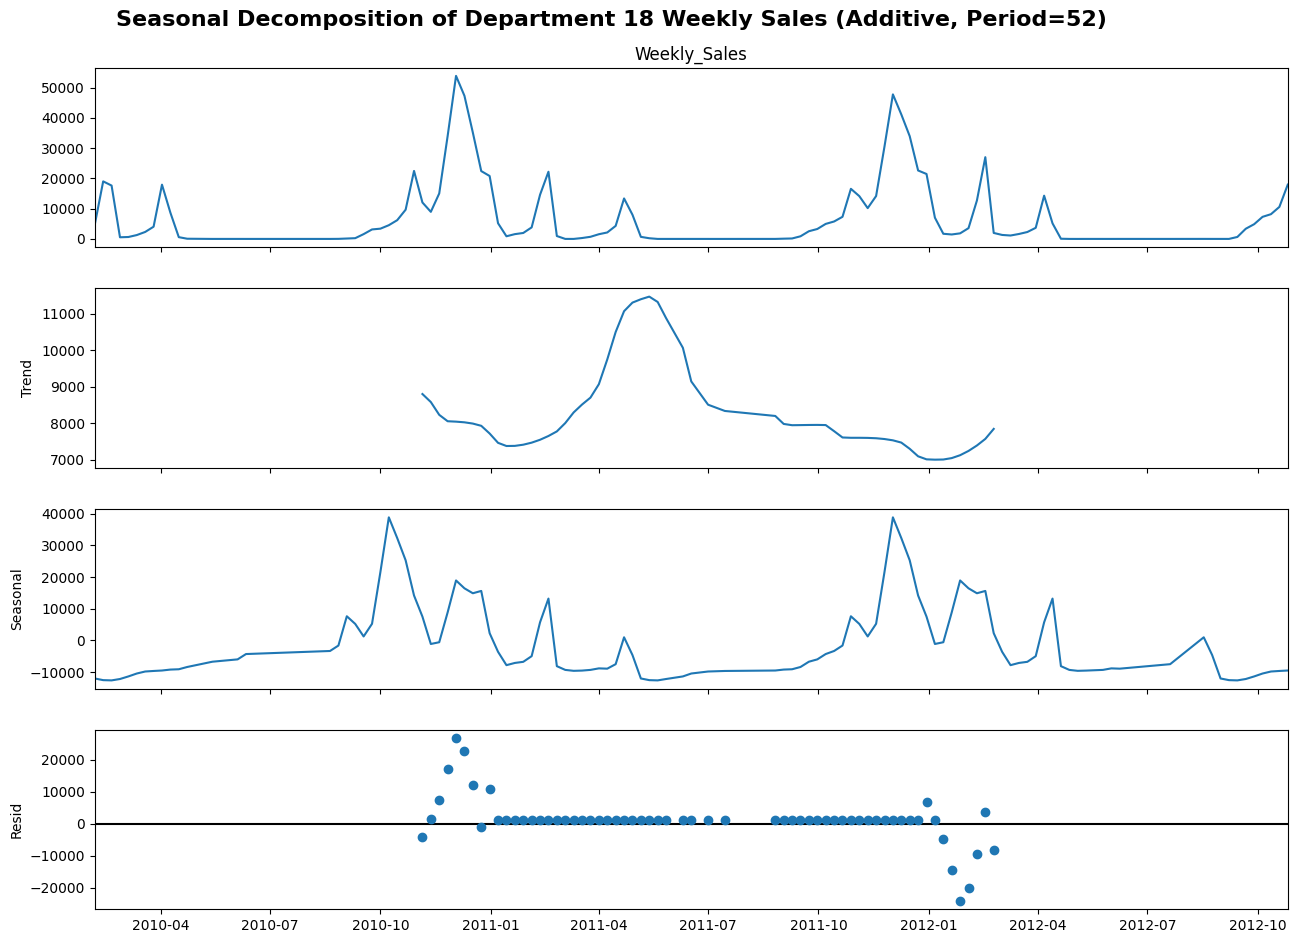

Additive decomposition completed successfully

Decomposition Analysis:
• Trend component range: $7004.46 to $11463.83
• Seasonal component range: $-12621.89 to $38892.01
• Residual component std: $7402.40


In [ ]:
# Seasonal Decomposition

# Seasonal Decomposition Plot for Department 18 Weekly Sales
# Using both additive and multiplicative models with appropriate period

print("SEASONAL DECOMPOSITION ANALYSIS")
print("=" * 50)

# For weekly data, we'll use different periods to capture seasonality
# Period 52: Annual seasonality (52 weeks in a year)
# Period 4: Monthly seasonality (approximately 4 weeks in a month)

# annual seasonality (52 weeks)
try:
    # Multiplicative decomposition
    decomposition_mult = seasonal_decompose(dept18_df['Weekly_Sales'],
                                          model='multiplicative',
                                          period=52)

    fig = decomposition_mult.plot()
    fig.set_size_inches(15, 10)
    plt.suptitle('Seasonal Decomposition of Department 18 Weekly Sales (Multiplicative, Period=52)',fontsize=16, fontweight='bold')
    plt.show()

    print(" Multiplicative decomposition completed successfully")

except Exception as e:
    print(f"Multiplicative decomposition failed: {e}")

# Additive decomposition
try:
    decomposition_add = seasonal_decompose(dept18_df['Weekly_Sales'],
                                         model='additive',
                                         period=52)

    fig = decomposition_add.plot()
    fig.set_size_inches(15, 10)
    plt.suptitle('Seasonal Decomposition of Department 18 Weekly Sales (Additive, Period=52)',fontsize=16, fontweight='bold')
    plt.show()

    print("Additive decomposition completed successfully")

    # Analyze the components
    print("\nDecomposition Analysis:")
    print(f"• Trend component range: ${decomposition_add.trend.min():.2f} to ${decomposition_add.trend.max():.2f}")
    print(f"• Seasonal component range: ${decomposition_add.seasonal.min():.2f} to ${decomposition_add.seasonal.max():.2f}")
    print(f"• Residual component std: ${decomposition_add.resid.std():.2f}")

except Exception as e:
    print(f"Additive decomposition failed: {e}")



Insights:

Additive decomposition succeeded; multiplicative failed due to negative values.

The seasonal component shows clear repeating yearly patterns.

The residual component is quite noisy, indicating irregular fluctuations outside trend and seasonality.

Trend component gradually declines over time.

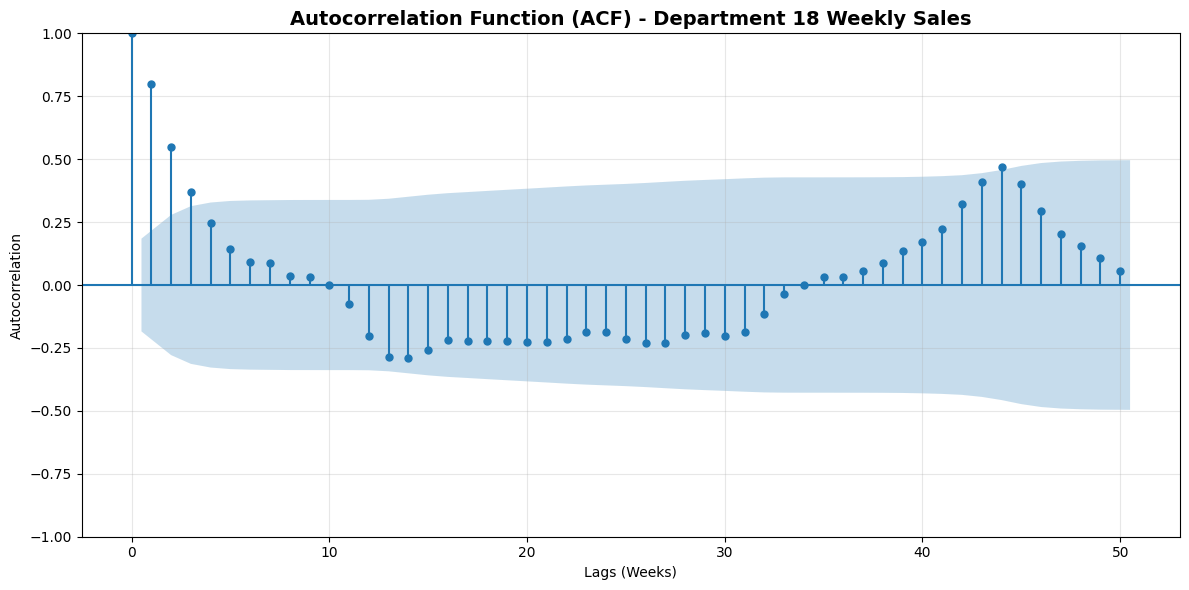

In [ ]:
# Plot the autocorrelation (ACF) of Department 18 Weekly Sales
# ACF shows correlation between observations at different lags

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(dept18_df['Weekly_Sales'], lags=50, ax=ax, alpha=0.05 )
plt.title('Autocorrelation Function (ACF) - Department 18 Weekly Sales',  fontsize=14, fontweight='bold')
plt.xlabel('Lags (Weeks)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


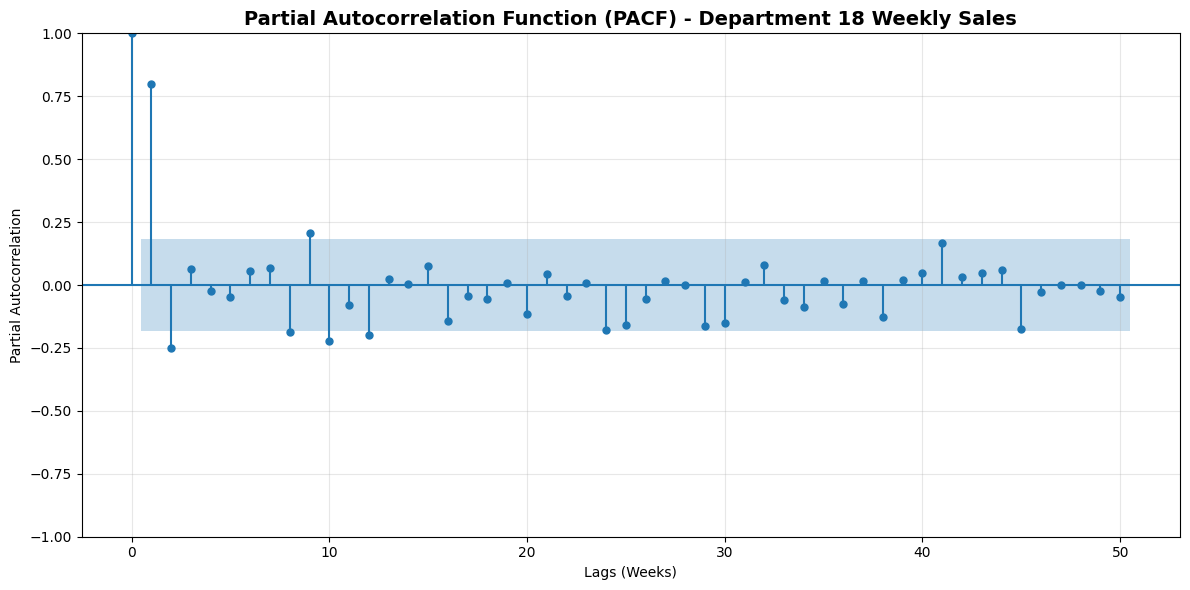

In [ ]:
# Plot the partial autocorrelation (PACF) of Department 18 Weekly Sales
# PACF shows correlation between observations at different lags, controlling for shorter lags

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(dept18_df['Weekly_Sales'], lags=50, ax=ax, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) - Department 18 Weekly Sales',fontsize=14, fontweight='bold')
plt.xlabel('Lags (Weeks)')
plt.ylabel('Partial Autocorrelation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Prepare the Data

Dataset shape: (113, 7)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Original data points: 113
Negative values: 1

Train set: 90
Test set: 23 
Train date range: 2010-02-05 00:00:00 to 2012-03-16 00:00:00
Test date range: 2012-03-23 00:00:00 to 2012-10-26 00:00:00


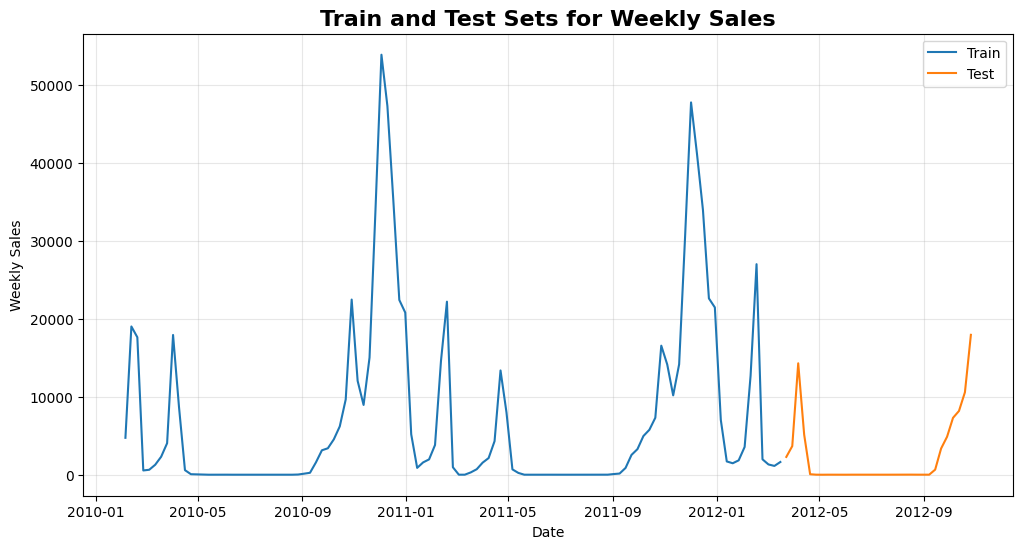

In [83]:
# This section loads the sales data, adjusts negative values (needed for multiplicative models),
# and splits the dataset into training and testing sets.

print(f"Dataset shape: {dept18_df.shape}")
print(f"Date range: {dept18_df.index.min()} to {dept18_df.index.max()}")

sales_data = dept18_df['Weekly_Sales'].copy()
print(f"Original data points: {len(sales_data)}")
print(f"Negative values: {(sales_data < 0).sum()}")

sales_positive = sales_data + abs(sales_data.min()) + 1 if sales_data.min() <= 0 else sales_data

train_size = int(0.8 * len(sales_data))
train_data = sales_data[:train_size]
test_data = sales_data[train_size:]
train_positive = sales_positive[:train_size]
test_positive = sales_positive[train_size:]

print(f"\nTrain set: {len(train_data)}")
print(f"Test set: {len(test_data)} ")
print(f"Train date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test date range: {test_data.index.min()} to {test_data.index.max()}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data.index, train_data, label='Train')
ax.plot(test_data.index, test_data, label='Test')
ax.set_title('Train and Test Sets for Weekly Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()




## Helper Functions

In [84]:
# Helper Functions
# This section defines helper functions to calculate evaluation metrics (MAE, MSE, RMSE, MAPE)
# and plot forecasts with optional confidence intervals.

def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

def plot_forecast(actual_train, actual_test, forecast, model_name, confidence_intervals=None):
    plt.figure(figsize=(15, 8))
    plt.plot(actual_train.index, actual_train.values, label='Training Data', color='blue', alpha=0.7)
    plt.plot(actual_test.index, actual_test.values, label='Actual Test Data', color='green', linewidth=2)
    plt.plot(actual_test.index, forecast, label='Forecast', color='red', linewidth=2, linestyle='--')
    if confidence_intervals is not None:
        plt.fill_between(actual_test.index,
                         confidence_intervals.iloc[:, 0],
                         confidence_intervals.iloc[:, 1],
                         color='red', alpha=0.2, label='Confidence Interval')
    plt.title(f'{model_name} - Forecast vs Actual', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

results = []
forecasts = {}


## Exponential Smoothing Family

### **Simple Exponential Smoothing (SES)**

Simple Exponential Smoothing assigns exponentially decreasing weights to past observations, giving more influence to recent data.

It is especially useful when there is no clear trend or seasonal pattern.

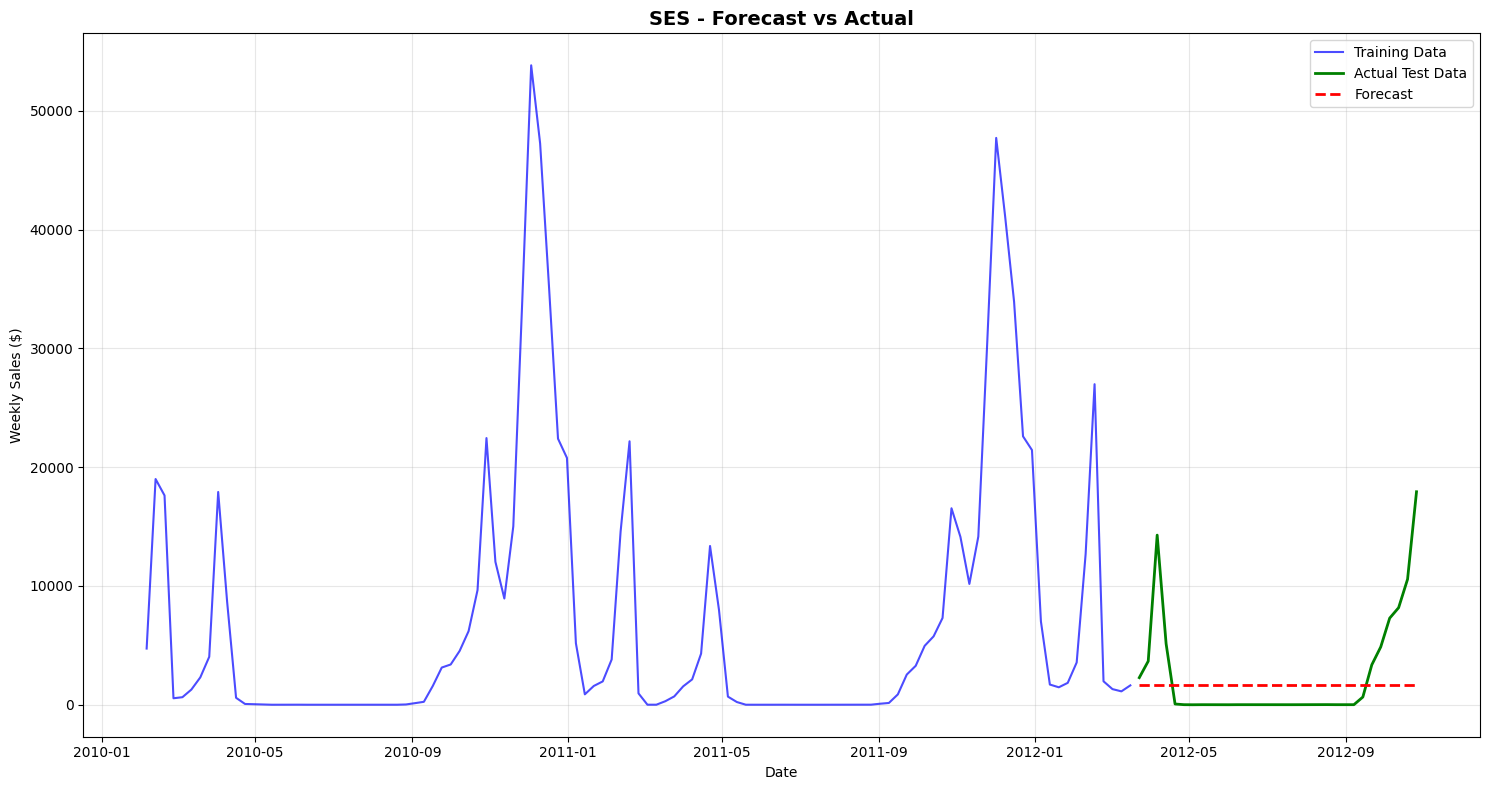

In [ ]:
ses_model = ExponentialSmoothing(train_data, trend=None, seasonal=None).fit()
ses_forecast = ses_model.forecast(steps=len(test_data))
ses_metrics = calculate_metrics(test_data, ses_forecast, 'SES')
results.append(ses_metrics)
forecasts['SES'] = ses_forecast
plot_forecast(train_data, test_data, ses_forecast, 'SES')


### **Double Exponential Smoothing (DES)**

Double Exponential Smoothing (DES), also known as Holt’s Linear Trend Model, is used when the time series data exhibits a trend.

Unlike Simple Exponential Smoothing, which is suitable for data without trends or seasonality, DES can account for both the level and the trend in the data

Key Features:
- Trend Handling -  making it suitable for time series data that show a consistent upward or downward trend over time.
- Components - DES involves two components: the level (smoothed value) and the trend.

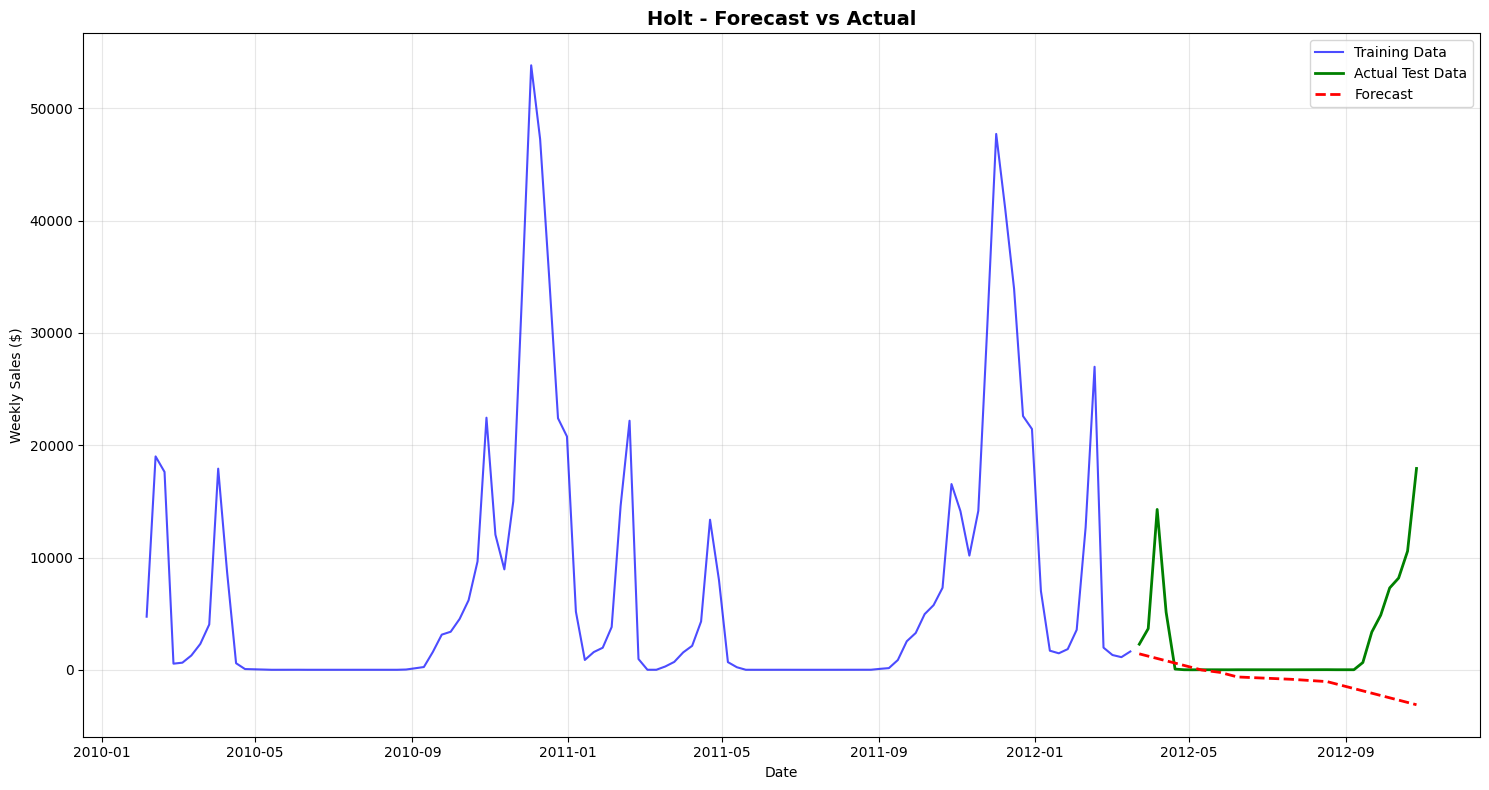

In [ ]:
holt_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(steps=len(test_data))
holt_metrics = calculate_metrics(test_data, holt_forecast, 'Holt')
results.append(holt_metrics)
forecasts['Holt'] = holt_forecast
plot_forecast(train_data, test_data, holt_forecast, 'Holt')

### **Triple Exponential Smoothing (Holt-Winters method)**

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, extends Double Exponential Smoothing by adding a seasonal component to handle data with seasonal patterns in addition to trends.

Key Features:
- Seasonality Handling - Triple Exponential Smoothing accommodates time series data with seasonal patterns, which can be daily, weekly, monthly, quarterly, or annual.
- Components - It involves three components: level (smoothed value), trend, and seasonal.

In [ ]:
# Holt-Winters Additive
if len(train_data) >= 2 * 52:
    hw_add_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=52).fit()
    hw_add_forecast = hw_add_model.forecast(steps=len(test_data))
    hw_add_metrics = calculate_metrics(test_data, hw_add_forecast, 'HW Add')
    results.append(hw_add_metrics)
    forecasts['HW_Add'] = hw_add_forecast
    plot_forecast(train_data, test_data, hw_add_forecast, 'HW Add')
else:
    print("HW Additive requires at least 2 full seasonal cycles (104 data points). Skipping this model.")

HW Additive requires at least 2 full seasonal cycles (104 data points). Skipping this model.


In [ ]:
# Holt-Winters Multiplicative
if len(train_data) >= 2 * 52:
    hw_mult_model = ExponentialSmoothing(train_positive, trend='add', seasonal='mul', seasonal_periods=52).fit()
    hw_mult_forecast_pos = hw_mult_model.forecast(steps=len(test_data))
    hw_mult_forecast = hw_mult_forecast_pos - abs(sales_data.min()) - 1 if sales_data.min() <= 0 else hw_mult_forecast_pos
    hw_mult_metrics = calculate_metrics(test_data, hw_mult_forecast, 'HW Mult')
    results.append(hw_mult_metrics)
    forecasts['HW_Mult'] = hw_mult_forecast
    plot_forecast(train_data, test_data, hw_mult_forecast, 'HW Mult')
else:
    print("HW Multiplicative requires at least 2 full seasonal cycles (104 data points). Skipping this model.")

HW Multiplicative requires at least 2 full seasonal cycles (104 data points). Skipping this model.


### Damped Trend Models

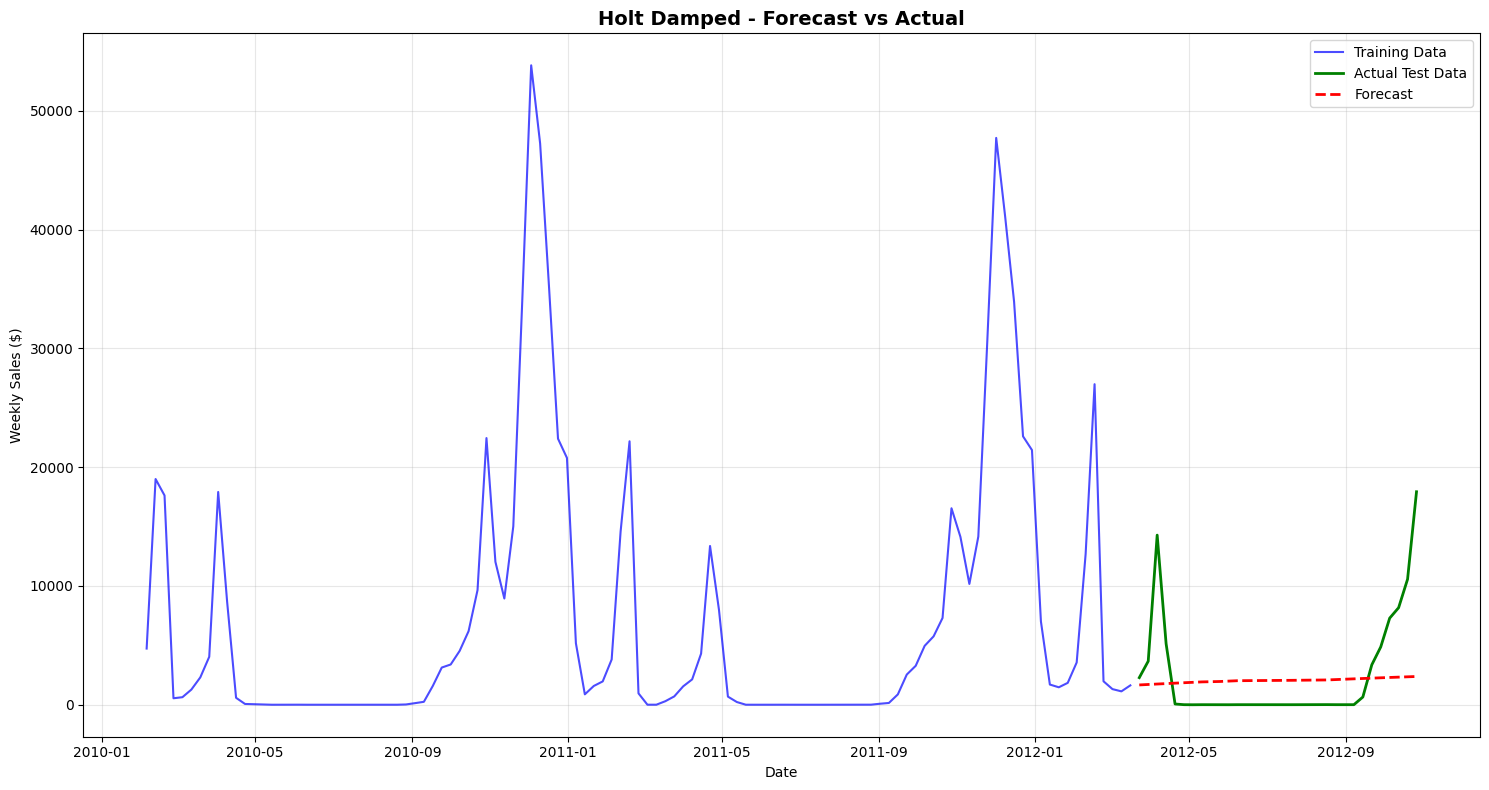

HW Additive Damped requires at least 2 full seasonal cycles (104 data points).


In [ ]:
# What this part does:
# It adds two extra models:
# 1. Holt’s Linear Trend with damping
# 2. Holt-Winters Additive with damping

# Why is this useful?
# Some time series data shows a trend (e.g. steadily increasing sales), but trends don’t last forever.
# For example:
# - A product might keep growing for some time...
# - But eventually, growth slows down or stops.
#
# Damped trend models fix this by slowing down the trend over time.
# This helps make more realistic long-term forecasts.
#
# Benefit:
# - Adds more model options.
# - Helps reduce over-prediction or unrealistic trends.
# - Might give lower RMSE or MAPE, which means better performance.

# Holt’s Linear Trend with Damping (no seasonality)
holt_damped = ExponentialSmoothing(train_data, trend='add', seasonal=None, damped_trend=True).fit()
holt_damped_forecast = holt_damped.forecast(steps=len(test_data))
holt_damped_metrics = calculate_metrics(test_data, holt_damped_forecast, 'Holt Damped')
results.append(holt_damped_metrics)
forecasts['Holt_Damped'] = holt_damped_forecast
plot_forecast(train_data, test_data, holt_damped_forecast, 'Holt Damped')

# Holt-Winters Additive with Damped Trend (requires full seasonal cycles)
if len(train_data) >= 2 * 52:
    hw_add_damped = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=52, damped_trend=True).fit()
    hw_add_damped_forecast = hw_add_damped.forecast(steps=len(test_data))
    hw_add_damped_metrics = calculate_metrics(test_data, hw_add_damped_forecast, 'HW Add Damped')
    results.append(hw_add_damped_metrics)
    forecasts['HW_Add_Damped'] = hw_add_damped_forecast
    plot_forecast(train_data, test_data, hw_add_damped_forecast, 'HW Add Damped')
else:
    print("HW Additive Damped requires at least 2 full seasonal cycles (104 data points).")

### MODEL COMPARISON


Model Performance Ranking (by RMSE):
         Model         RMSE          MAPE
2  Holt Damped  5106.667609  69115.256986
0          SES  5290.390500  56559.273632
1         Holt  7031.908190  17235.716209


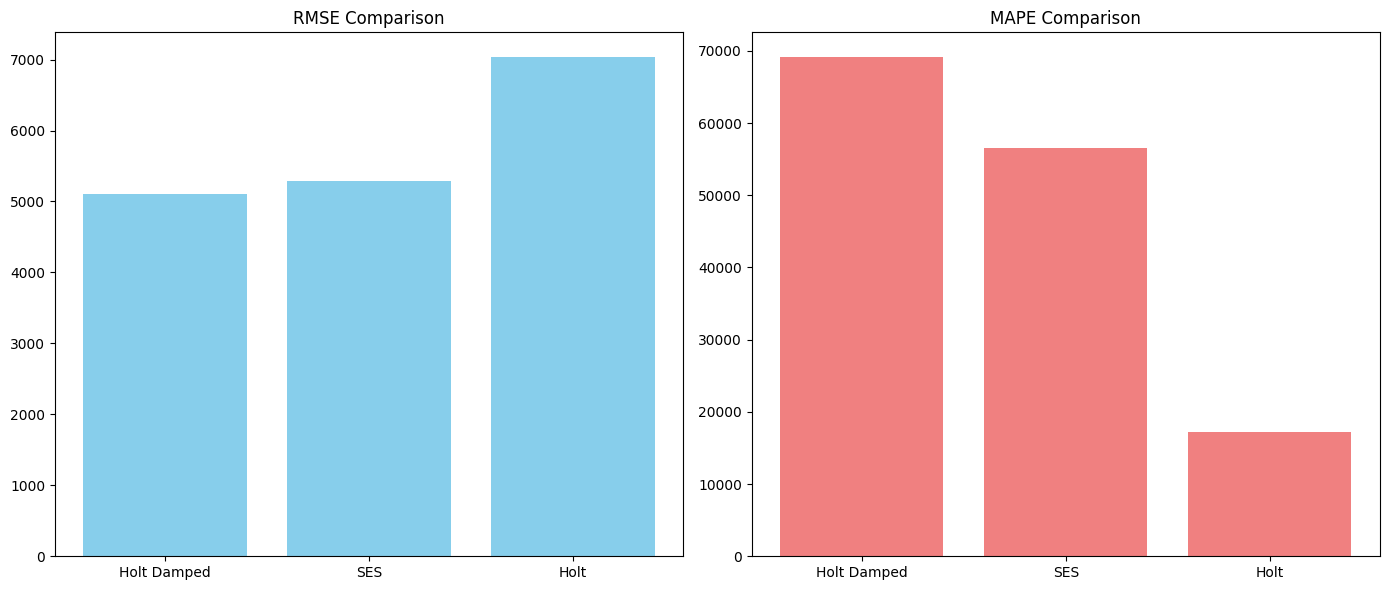

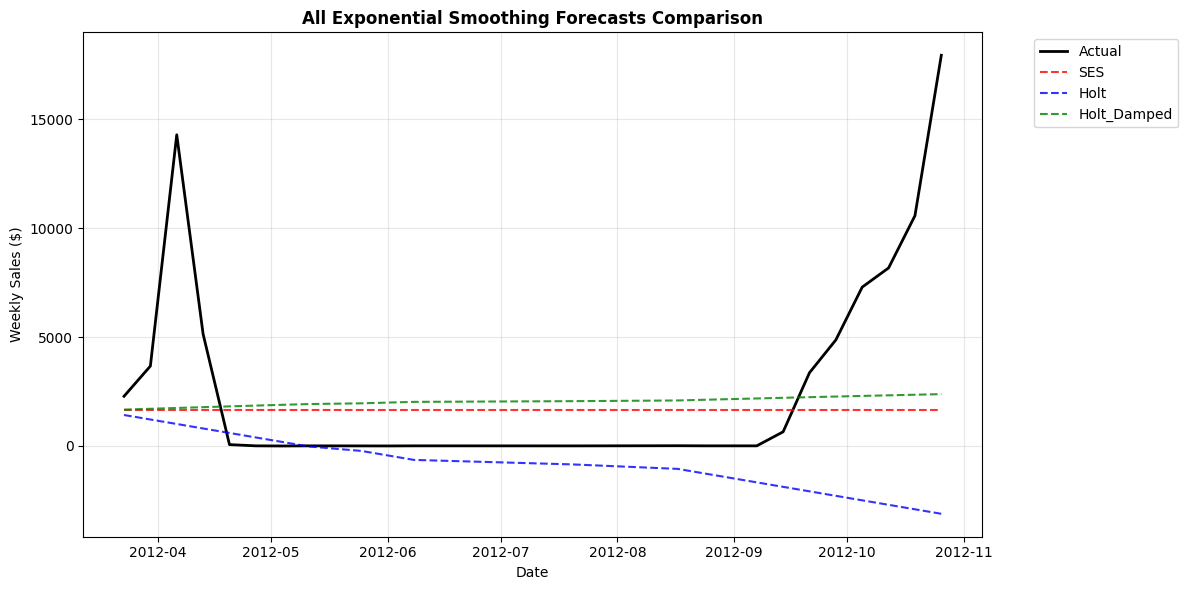

In [ ]:
# RMSE (Root Mean Squared Error): measures how far the forecast is from actual values (lower is better)

# MAPE (Mean Absolute Percentage Error): measures prediction accuracy in percentages (lower is better)

results_df = pd.DataFrame(results).sort_values('RMSE')

print("\nModel Performance Ranking (by RMSE):")
print(results_df[['Model', 'RMSE', 'MAPE']])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.title('RMSE Comparison')
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['MAPE'], color='lightcoral')
plt.title('MAPE Comparison')
plt.tight_layout()
plt.show()

# Subplot 3: All forecasts comparison
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual', color='black', linewidth=2)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, (model_name, forecast) in enumerate(forecasts.items()):
    plt.plot(test_data.index, forecast,
             label=model_name,
             color=colors[i % len(colors)],
             linestyle='--',
             alpha=0.8)

plt.title('All Exponential Smoothing Forecasts Comparison', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 📊 Insights from Model Performance Comparison

1. **Best RMSE – Holt Damped Model**
   - The Holt Damped model achieved the lowest RMSE (5106.67), which means it gave the most accurate forecasts in terms of absolute error.
   - Damped models are useful when trends are expected to slow down over time, which helped improve its performance here.

2. **SES Model – Slightly Higher Error**
   - The Simple Exponential Smoothing (SES) model came second with an RMSE of 5290.39, which is slightly worse than Holt Damped.
   - It doesn’t account for trends, yet still performed fairly well — indicating the data may not have a strong trend component.

3. **Holt Linear Trend – Weakest Performance**
   - The Holt model, which assumes a consistent trend, had the highest RMSE (7031.91).
   - This may suggest that the actual trend in the data is not stable, or it changes over time, making the basic trend model less suitable.

4. **Very High MAPE Values**
   - All models have extremely high MAPE values, especially Holt Damped (69,115%) and SES (56,559%).
   - This usually happens when actual values in the test set are small or near zero, which causes percentage-based errors to explode.


## Stationarity Test

- A **stationary time series** is one where **mean, variance, and autocorrelation structure remain constant over time**.
- Many time series models (like ARIMA) assume that the data is stationary to make reliable predictions.

`adfuller` - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

In [ ]:
# Drop missing values from Weekly_Sales
sales = dept18_df['Weekly_Sales'].dropna()

# Run the ADF test
result = adfuller(sales)


print("ADF Test - Weekly Sales")
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

# Check if series is stationary
if result[1] <= 0.05:
    print("✅ The series is stationary (no trend).")
else:
    print("❌ The series is not stationary (has trend).")

ADF Test - Weekly Sales
ADF Statistic: -3.541
p-value: 0.007
✅ The series is stationary (no trend).


Insights:

The Augmented Dickey-Fuller (ADF) test gave a p-value of 0.007, which is less than 0.05.
This means the Weekly Sales series is stationary, and does not have a strong trend over time.
This is good for time series modeling, especially for methods like ARIMA, which assume stationarity.

## ARIMA Family Models

### ARIMA

In [ ]:
# ARIMA MODEL - PARAMETER SEARCH


print("\nARIMA MODEL")
print("-" * 40)

# Grid search for best ARIMA parameters

best_aic = np.inf
best_arima_params = None
best_arima_model = None

# Test different parameter combinations
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                fitted_model = model.fit()

                if fitted_model.aic < best_aic:
                    best_aic = fitted_model.aic
                    best_arima_params = (p, d, q)
                    best_arima_model = fitted_model

            except:
                continue

print(f"Best ARIMA parameters: {best_arima_params}")
print(f"Best AIC: {best_aic:.2f}")



ARIMA MODEL
----------------------------------------
Best ARIMA parameters: (3, 1, 2)
Best AIC: 1840.37



ARIMA (3, 1, 2) Performance:
MAE: 6205.24
RMSE: 6861.69
MAPE: 286647.76%


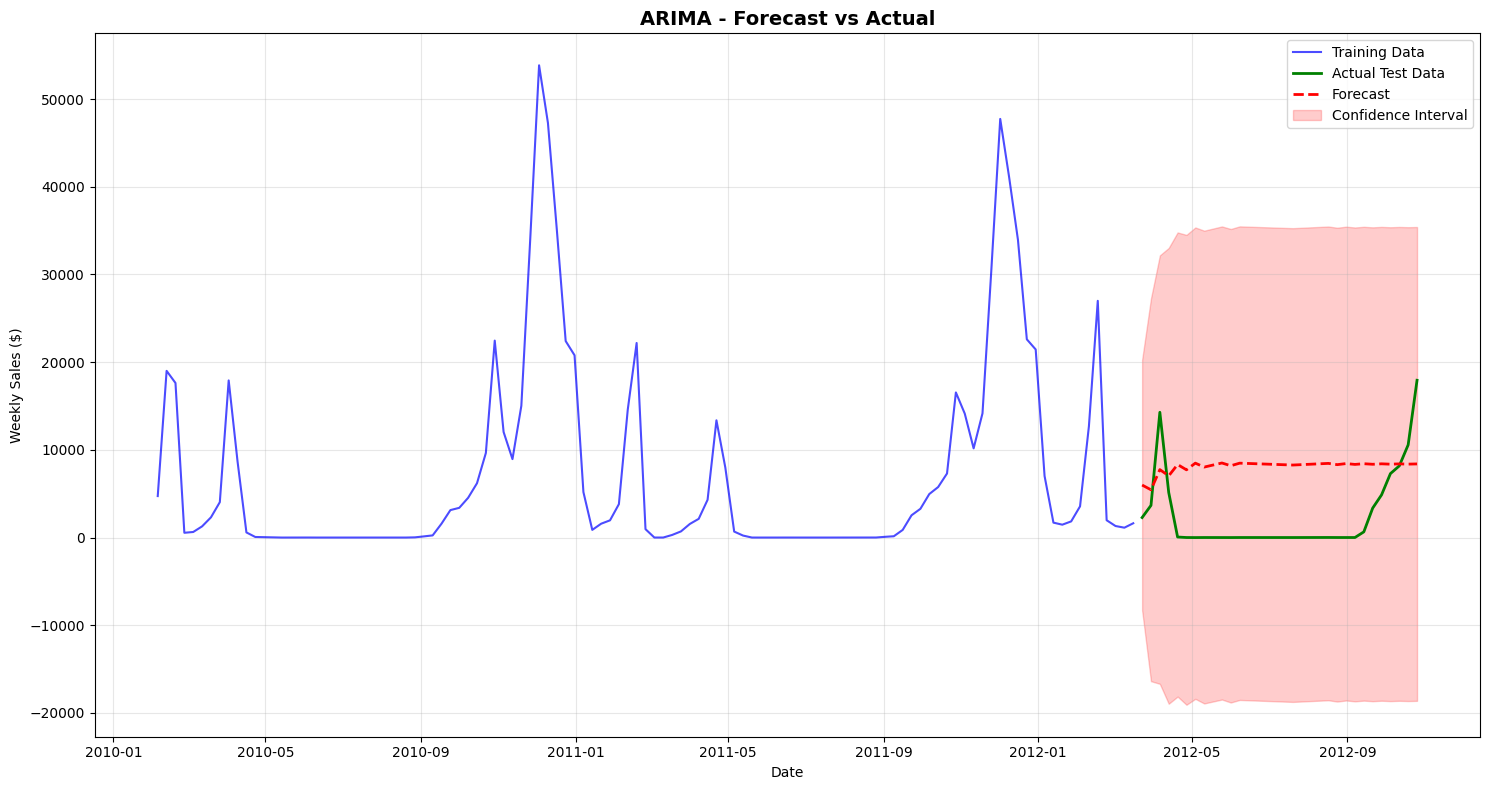

In [ ]:
# ARIMA MODEL - FORECAST AND EVALUATION

# Generate ARIMA forecast
arima_forecast = best_arima_model.forecast(steps=len(test_data))
arima_conf_int = best_arima_model.get_forecast(steps=len(test_data)).conf_int()

# Calculate metrics
arima_metrics = calculate_metrics(test_data, arima_forecast, 'ARIMA')
results.append(arima_metrics)
forecasts['ARIMA'] = arima_forecast

print(f"\nARIMA {best_arima_params} Performance:")
print(f"MAE: {arima_metrics['MAE']:.2f}")
print(f"RMSE: {arima_metrics['RMSE']:.2f}")
print(f"MAPE: {arima_metrics['MAPE']:.2f}%")

plot_forecast(train_data, test_data, arima_forecast, 'ARIMA', arima_conf_int)

### SARIMA

In [ ]:
# SARIMA MODEL - PARAMETER SEARCH

print("\nSARIMA MODEL")
print("-" * 40)

# Search for best SARIMA parameters (limited range for speed)

best_sarima_aic = np.inf
best_sarima_params = None
best_sarima_seasonal = None
best_sarima_model = None

# Parameter ranges (limited for computational efficiency)
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 2)
D_range = range(0, 2)
Q_range = range(0, 2)

param_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))
print(f"Testing {len(param_combinations)} SARIMA combinations...")

for i, (p, d, q, P, D, Q) in enumerate(param_combinations):
    try:
        model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 52))
        fitted_model = model.fit(disp=False)

        if fitted_model.aic < best_sarima_aic:
            best_sarima_aic = fitted_model.aic
            best_sarima_params = (p, d, q)
            best_sarima_seasonal = (P, D, Q, 52)
            best_sarima_model = fitted_model

    except:
        continue

    # Progress update
    if (i + 1) % 20 == 0:
        print(f"Progress: {i + 1}/{len(param_combinations)} tested")

print(f"Best SARIMA parameters: {best_sarima_params}")
print(f"Best seasonal parameters: {best_sarima_seasonal}")
print(f"Best AIC: {best_sarima_aic:.2f}")



SARIMA MODEL
----------------------------------------
Testing 144 SARIMA combinations...
Progress: 20/144 tested
Progress: 40/144 tested
Progress: 60/144 tested
Progress: 80/144 tested
Progress: 100/144 tested
Progress: 120/144 tested
Progress: 140/144 tested
Best SARIMA parameters: (0, 1, 2)
Best seasonal parameters: (1, 1, 0, 52)
Best AIC: 8.00



SARIMA (0, 1, 2) x (1, 1, 0, 52) Performance:
MAE: 3405.19
RMSE: 6035.26
MAPE: 100.00%


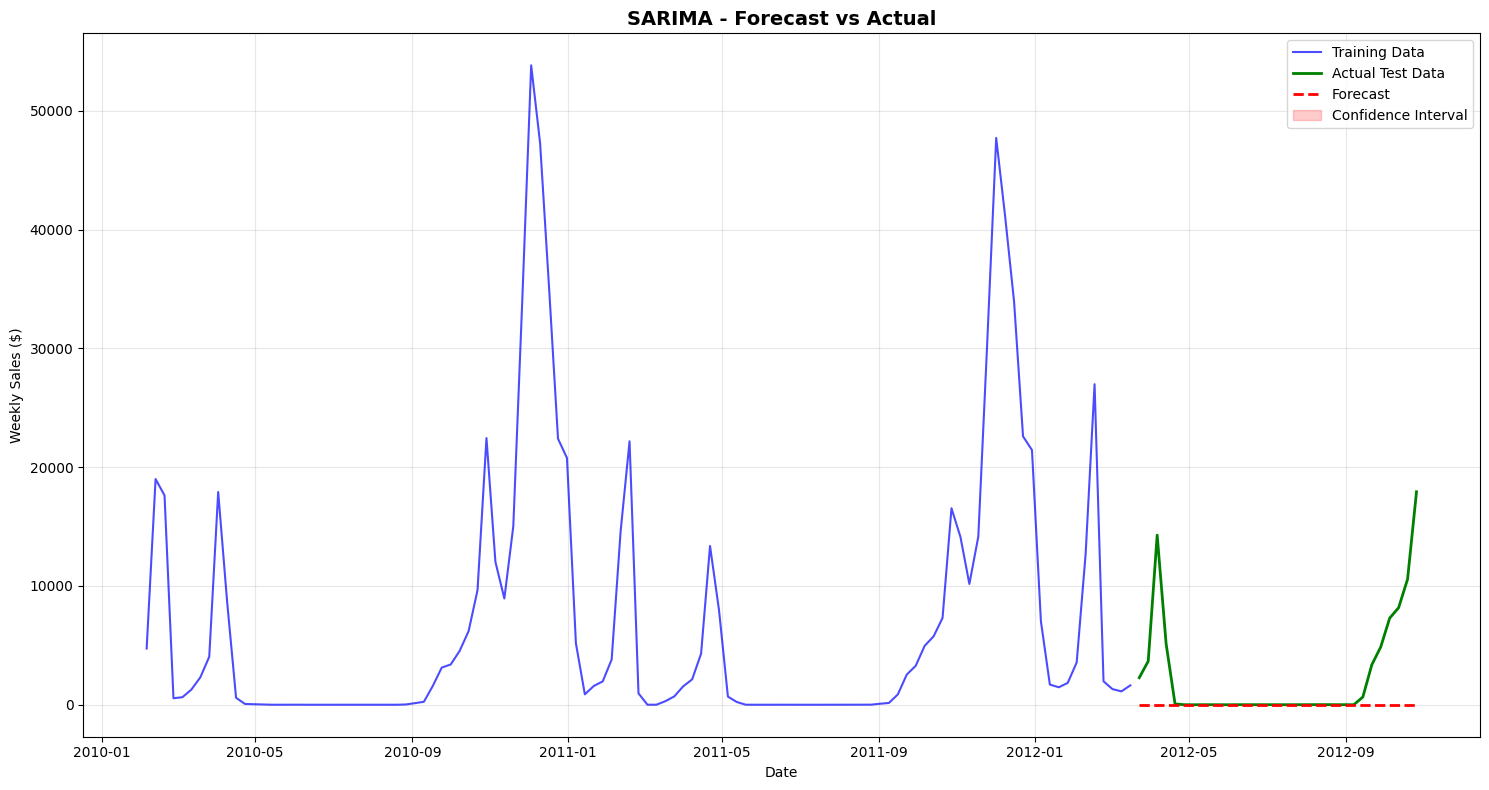

In [ ]:
# SARIMA MODEL - FORECAST AND EVALUATION

# Generate SARIMA forecast
sarima_forecast = best_sarima_model.forecast(steps=len(test_data))
sarima_conf_int = best_sarima_model.get_forecast(steps=len(test_data)).conf_int()

# Calculate metrics
sarima_metrics = calculate_metrics(test_data, sarima_forecast, 'SARIMA')
results.append(sarima_metrics)
forecasts['SARIMA'] = sarima_forecast

print(f"\nSARIMA {best_sarima_params} x {best_sarima_seasonal} Performance:")
print(f"MAE: {sarima_metrics['MAE']:.2f}")
print(f"RMSE: {sarima_metrics['RMSE']:.2f}")
print(f"MAPE: {sarima_metrics['MAPE']:.2f}%")

plot_forecast(train_data, test_data, sarima_forecast, 'SARIMA', sarima_conf_int)

 ### SARIMAX

In [ ]:
# PREPARE EXTERNAL REGRESSORS FOR SARIMAX

print("\nSARIMAX MODEL - PREPARING EXTERNAL REGRESSORS")
print("-" * 40)

# Create empty DataFrames for external regressors
# These will match the indices (dates) of the training and testing data
train_exog = pd.DataFrame(index=train_data.index)
test_exog = pd.DataFrame(index=test_data.index)

# Add time-based features that can affect seasonality and trends
# 'month': captures monthly seasonal patterns (e.g., December sales spike)
# 'quarter': captures quarterly business cycles
# 'week_of_year': captures week-based patterns across the year

train_exog['month'] = train_data.index.month
train_exog['quarter'] = train_data.index.quarter
train_exog['week_of_year'] = train_data.index.isocalendar().week

test_exog['month'] = test_data.index.month
test_exog['quarter'] = test_data.index.quarter
test_exog['week_of_year'] = test_data.index.isocalendar().week

# Define a function to flag holiday weeks
def is_holiday_week(date):
    """Returns 1 if the date falls in a major US holiday week, else 0"""

    # Thanksgiving week (4th Thursday of November — simplified here)
    if date.month == 11 and date.weekday() == 3 and 22 <= date.day <= 28:
        return 1

    # Christmas week (Dec 20 to end of December)
    elif date.month == 12 and date.day >= 20:
        return 1

    # New Year week (first 7 days of January)
    elif date.month == 1 and date.day <= 7:
        return 1

    # Memorial Day (last Monday in May — simplified by checking last week of May)
    elif date.month == 5 and date.weekday() == 0 and date.day >= 25:
        return 1

    # Labor Day (first Monday in September — simplified)
    elif date.month == 9 and date.weekday() == 0 and date.day <= 7:
        return 1

    # Not a holiday week
    else:
        return 0

# Apply the holiday function to every date in the training and testing data
train_exog['is_holiday'] = [is_holiday_week(date) for date in train_data.index]
test_exog['is_holiday'] = [is_holiday_week(date) for date in test_data.index]

# Show the shape of the external regressors to confirm dimensions
print(f"External regressors shape - Train: {train_exog.shape}, Test: {test_exog.shape}")

# Display the first few rows of the training regressors to preview the data
print("\nExternal regressors preview:")
print(train_exog.head())



SARIMAX MODEL - PREPARING EXTERNAL REGRESSORS
----------------------------------------
External regressors shape - Train: (90, 4), Test: (23, 4)

External regressors preview:
            month  quarter  week_of_year  is_holiday
Date                                                
2010-02-05      2        1             5           0
2010-02-12      2        1             6           0
2010-02-19      2        1             7           0
2010-02-26      2        1             8           0
2010-03-05      3        1             9           0


In [ ]:
train_exog = train_exog.apply(pd.to_numeric, errors='coerce').fillna(0)
test_exog = test_exog.apply(pd.to_numeric, errors='coerce').fillna(0)




In [ ]:
# Convert all exogenous variables to float
train_exog = train_exog.astype('float64')
test_exog = test_exog.astype('float64')


In [ ]:
print("Train data shape:", train_data.shape)
print("Train exog shape:", train_exog.shape)

print("Test data shape:", test_data.shape)
print("Test exog shape:", test_exog.shape)


Train data shape: (90,)
Train exog shape: (90, 4)
Test data shape: (23,)
Test exog shape: (23, 4)


In [ ]:
# Convert train_data and test_data to DataFrames
train_data = train_data.to_frame(name='Weekly_Sales')
test_data = test_data.to_frame(name='Weekly_Sales')



In [ ]:
# SARIMAX MODEL - PARAMETER SEARCH

print("\nSearching for best SARIMAX parameters...")

# Ensure exog is numeric
train_exog = train_exog.apply(pd.to_numeric, errors='coerce').fillna(0)
test_exog = test_exog.apply(pd.to_numeric, errors='coerce').fillna(0)

# Test a few SARIMAX parameter combinations
sarimax_candidates = [
    ((1, 1, 1), (1, 1, 1, 52)),
    ((2, 1, 2), (1, 1, 1, 52)),
    ((1, 1, 2), (1, 1, 1, 52)),
    ((0, 1, 1), (0, 1, 1, 52)),
    ((1, 0, 1), (1, 1, 1, 52))
]

best_sarimax_aic = float('inf')
best_sarimax_model = None
best_sarimax_params = None

for params, seasonal_params in sarimax_candidates:
    try:
        model = SARIMAX(train_data,
                        exog=train_exog,
                        order=params,
                        seasonal_order=seasonal_params)
        fitted_model = model.fit(disp=False)
        print(f"SARIMAX {params} x {seasonal_params} - AIC: {fitted_model.aic:.2f}")

        if fitted_model.aic < best_sarimax_aic:
            best_sarimax_aic = fitted_model.aic
            best_sarimax_model = fitted_model
            best_sarimax_params = (params, seasonal_params)
    except Exception as e:
        print(f"Failed SARIMAX {params} x {seasonal_params}: {e}")

if best_sarimax_model is not None:
    print(f"\n✅ Best SARIMAX: {best_sarimax_params[0]} x {best_sarimax_params[1]}")
    print(f"✅ Best AIC: {best_sarimax_aic:.2f}")
else:
    print("\n❌ No SARIMAX model was successfully fitted.")



Searching for best SARIMAX parameters...
SARIMAX (1, 1, 1) x (1, 1, 1, 52) - AIC: 787.89
SARIMAX (2, 1, 2) x (1, 1, 1, 52) - AIC: 22.00
SARIMAX (1, 1, 2) x (1, 1, 1, 52) - AIC: 788.91
SARIMAX (0, 1, 1) x (0, 1, 1, 52) - AIC: 794.01
SARIMAX (1, 0, 1) x (1, 1, 1, 52) - AIC: 805.50

✅ Best SARIMAX: (2, 1, 2) x (1, 1, 1, 52)
✅ Best AIC: 22.00



SARIMAX (2, 1, 2) x (1, 1, 1, 52) Performance:
MAE: 410155.30
RMSE: 543645.07
MAPE: 9839010.97%


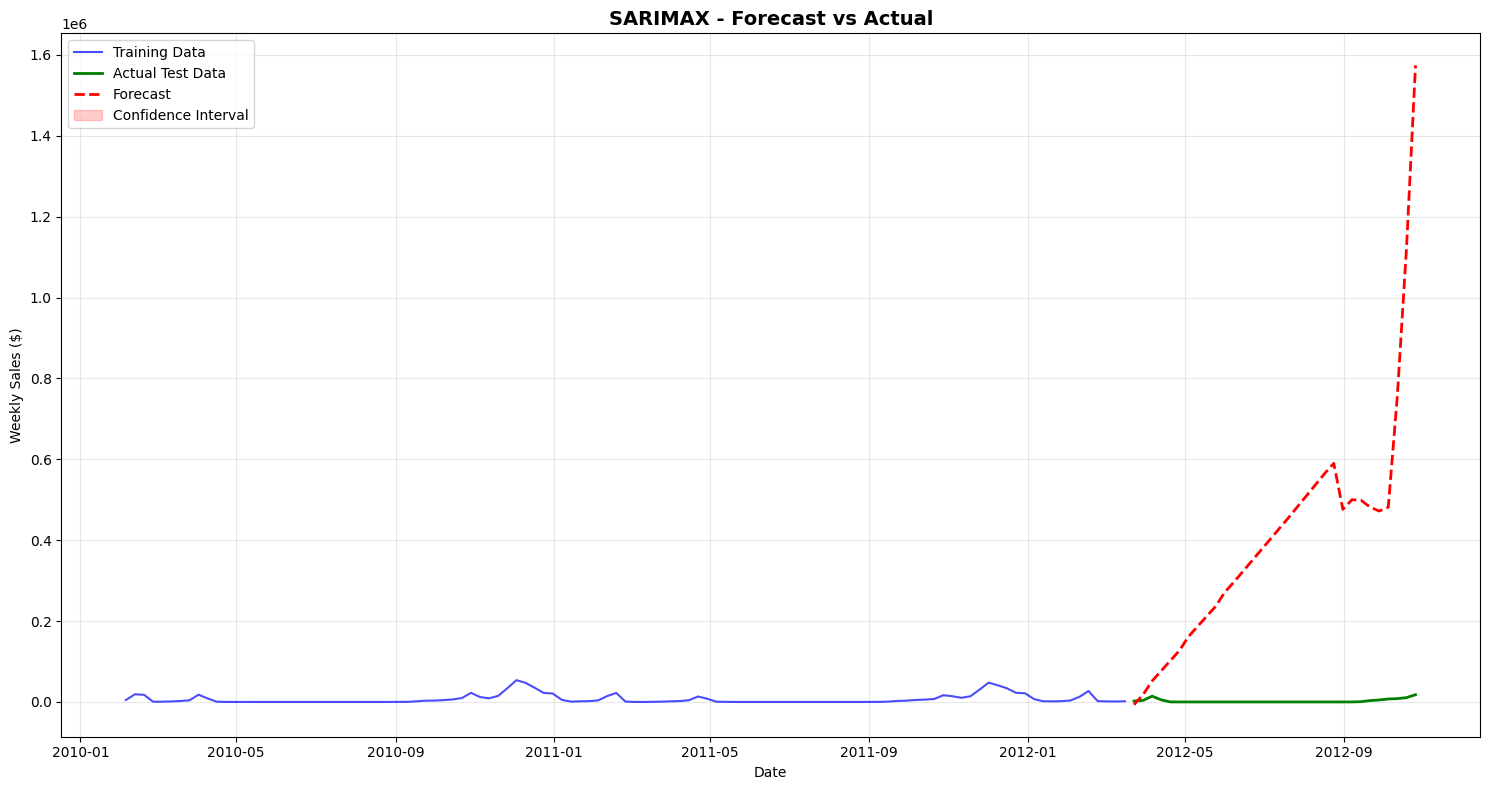

In [ ]:
# SARIMAX MODEL - FORECAST AND EVALUATION

if best_sarimax_model is not None:
    # Generate SARIMAX forecast
    # Generate out-of-sample forecast for the same length as the test set
    # Use test external regressors (exog) during prediction
    sarimax_forecast = best_sarimax_model.forecast(steps=len(test_data), exog=test_exog)

    # Get confidence intervals for the forecast (used for plotting uncertainty bounds)
    sarimax_conf_int = best_sarimax_model.get_forecast(steps=len(test_data), exog=test_exog).conf_int()

    # Calculate metrics
    sarimax_metrics = calculate_metrics(test_data, sarimax_forecast, 'SARIMAX')
    results.append(sarimax_metrics)
    forecasts['SARIMAX'] = sarimax_forecast

    print(f"\nSARIMAX {best_sarimax_params[0]} x {best_sarimax_params[1]} Performance:")
    print(f"MAE: {sarimax_metrics['MAE']:.2f}")
    print(f"RMSE: {sarimax_metrics['RMSE']:.2f}")
    print(f"MAPE: {sarimax_metrics['MAPE']:.2f}%")


    plot_forecast(train_data, test_data, sarimax_forecast, 'SARIMAX', sarimax_conf_int)

else:
    print("No SARIMAX model could be fitted successfully.")

### MODEL COMPARISON


ARIMA FAMILY MODELS COMPARISON
------------------------------------------------------------
ARIMA Family Results:
     Model        MAE           MSE       RMSE        MAPE
3    ARIMA    6205.24  4.708278e+07    6861.69   286647.76
4   SARIMA    3405.19  3.642441e+07    6035.26      100.00
5  SARIMAX  410155.30  2.955500e+11  543645.07  9839010.97


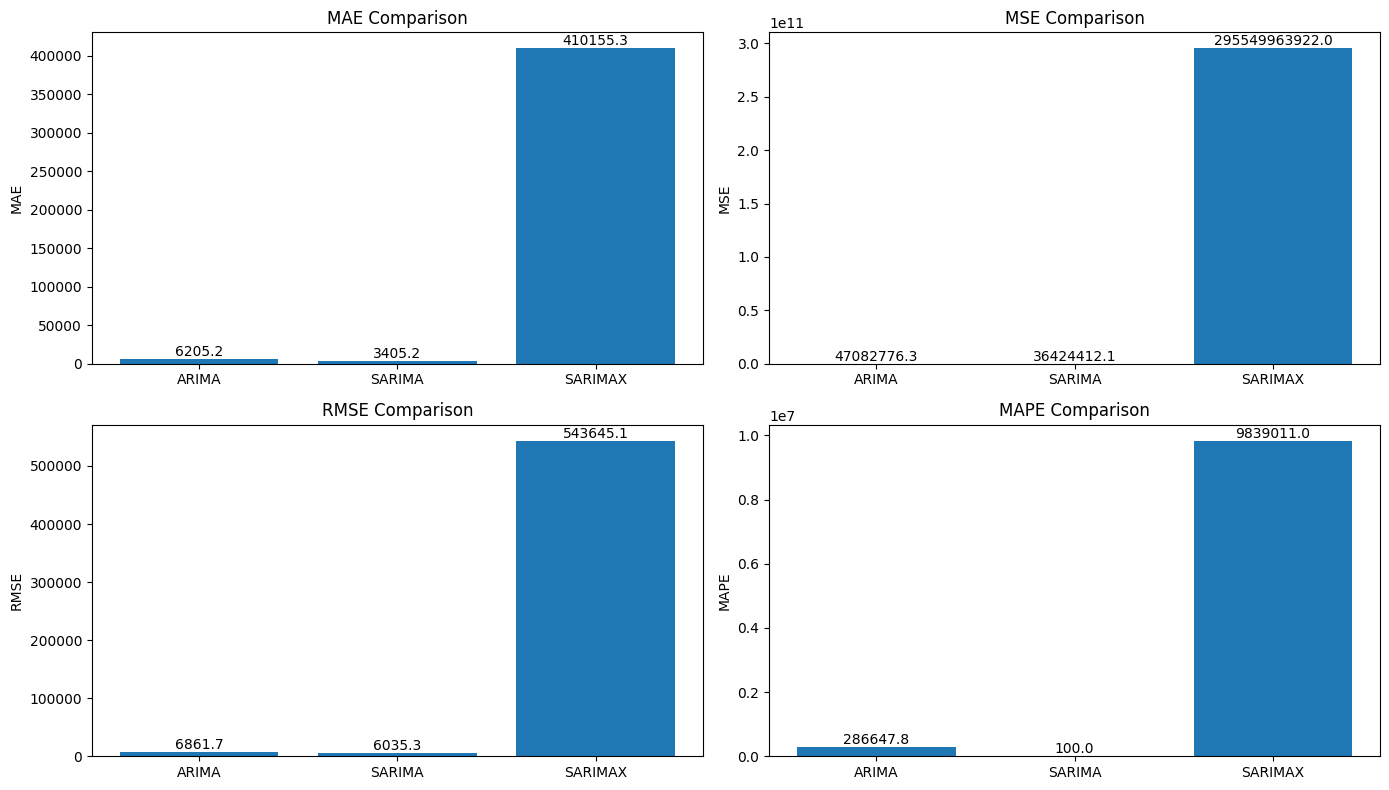


🏆 Best ARIMA family model: SARIMA (RMSE: 6035.26)


In [ ]:
print("\nARIMA FAMILY MODELS COMPARISON")
print("-" * 60)

# Filter results for ARIMA family models
arima_results = pd.DataFrame(results)
arima_results = arima_results[arima_results['Model'].isin(['ARIMA', 'SARIMA', 'SARIMAX'])].copy()

# Display rounded results
print("ARIMA Family Results:")
print(arima_results.round(2))

# Plot metrics if results exist
if not arima_results.empty:
    metrics = ['MAE', 'MSE', 'RMSE', 'MAPE']
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    for ax, metric in zip(axes.flatten(), metrics):
        bars = ax.bar(arima_results['Model'], arima_results[metric])
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}',
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Identify best model based on RMSE
    best_model = arima_results.loc[arima_results['RMSE'].idxmin()]
    print(f"\n🏆 Best ARIMA family model: {best_model['Model']} (RMSE: {best_model['RMSE']:.2f})")
else:
    print("No ARIMA family results to display.")




### 📊 Insights from Model Performance Comparison

- **SARIMA achieved the best performance** among the ARIMA family, with the **lowest RMSE of 6035.26** and **MAE of 3405.19**, making it the most suitable model for forecasting weekly sales.

- **ARIMA** showed reasonable results, with an RMSE of **6861.69** and MAE of **6205.24**, but its **MAPE was extremely high (286647.76%)**, possibly due to very small or zero actual values affecting percentage error.

- **SARIMAX performed very poorly**, with a drastically high **RMSE of 543645.07** and **MAPE of over 9 million percent**, indicating that the inclusion of external regressors severely degraded performance, likely due to poor alignment or uninformative features.

- The results suggest that adding external features (SARIMAX) does not always improve performance and can worsen results if not carefully engineered.


## Machine Learning Regressors

### Feature Engineering


🧠 Why Feature Engineering?

- **Transform time‑series into supervised format**  
  ML models like Random Forest and XGBoost need structured inputs (`X`) and targets (`y`). Feature engineering (lags, rolling averages, date features) reshapes sequential data into a table for modeling.

- **Capture temporal dependencies & trends**  
  - **Lag features** (e.g., previous 1–4 weeks of sales) give the model recent history context.  
  - **Rolling averages** smooth short-term noise and expose underlying trends.

- **Embed seasonality & calendar effects**  
  Features like month, week‑of‑year, holiday-season flags, and back-to-school indicators help the model learn recurring patterns and demand peaks.

- **Capture long‑term trend**  
  A simple trend index helps illustrate overall growth or decline over time.

- **Incorporate domain knowledge**  
  Adding features based on real-world events (holidays, school season) embeds expert insights, improving both accuracy and interpretability.

---

**✅ Summary:**  
Feature engineering converts raw date-indexed data into rich features—providing past behavior, seasonality, trend, and domain knowledge. This empowers ML models to learn patterns and deliver more accurate, explainable forecasts.


In [85]:
def create_simple_features(df, target_col='Weekly_Sales'):
    """
    Create easy-to-understand features for time series forecasting:
      - Lags: last 4 weeks of sales
      - Moving averages: 4, 8, and 12-week windows
      - Date features: month, quarter, week_of_year
      - Seasonal flags: holiday season, back-to-school
      - Trend index
    """

    features_df = df.copy()  # work on a copy to avoid modifying original

    # 1. LAG FEATURES – past Weekly_Sales values
    print("   → Adding lag features (previous weeks' sales)")
    for lag in [1, 2, 3, 4]:
        features_df[f'sales_lag_{lag}'] = features_df[target_col].shift(lag)

    # 2. MOVING AVERAGES – smooths short-term fluctuations
    print("   → Adding moving averages")
    features_df['sales_avg_4weeks'] = features_df[target_col].rolling(window=4).mean()
    features_df['sales_avg_8weeks'] = features_df[target_col].rolling(window=8).mean()
    features_df['sales_avg_12weeks'] = features_df[target_col].rolling(window=12).mean()

    # 3. DATE FEATURES – captures seasonality patterns
    print("   → Adding date features")
    features_df['month'] = features_df.index.month
    features_df['quarter'] = features_df.index.quarter
    features_df['week_of_year'] = features_df.index.isocalendar().week

    # 4. SEASONAL INDICATORS – mark special retail seasons
    print("   → Adding seasonal indicators")
    # Holiday season: Nov, Dec, Jan
    features_df['is_holiday_season'] = features_df['month'].isin([11, 12, 1]).astype(int)
    # Back-to-school: Aug, Sep
    features_df['is_back_to_school'] = features_df['month'].isin([8, 9]).astype(int)

    # 5. TREND FEATURE – helps capture overall upward/downward movement
    print("   → Adding trend feature")
    features_df['trend'] = np.arange(len(features_df))

    print("✅ Feature engineering completed!")
    return features_df


### Prepare The Data

In [86]:
# Create Features from Our Data

# Apply the feature engineering function to the Dept 18 dataframe
# This adds lag, rolling averages, date-based, seasonal, and trend features
dept18_with_features = create_simple_features(dept18_df)

# Prepare feature matrix (X) and target vector (y)
# X = all columns except 'Weekly_Sales'; y = the 'Weekly_Sales' column itself
feature_columns = [col for col in dept18_with_features.columns if col != 'Weekly_Sales']
X = dept18_with_features[feature_columns]
y = dept18_with_features['Weekly_Sales']

# Provide basic info about the features created
print(f"📊 Created {len(feature_columns)} features:")
print(f"   Features: {feature_columns}")
print(f"   Data shape: {X.shape}")


   → Adding lag features (previous weeks' sales)
   → Adding moving averages
   → Adding date features
   → Adding seasonal indicators
   → Adding trend feature
✅ Feature engineering completed!
📊 Created 19 features:
   Features: ['IsHoliday', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_avg_4weeks', 'sales_avg_8weeks', 'sales_avg_12weeks', 'month', 'quarter', 'week_of_year', 'is_holiday_season', 'is_back_to_school', 'trend']
   Data shape: (113, 19)


In [87]:
feature_columns

['IsHoliday',
 'Dept',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'sales_lag_1',
 'sales_lag_2',
 'sales_lag_3',
 'sales_lag_4',
 'sales_avg_4weeks',
 'sales_avg_8weeks',
 'sales_avg_12weeks',
 'month',
 'quarter',
 'week_of_year',
 'is_holiday_season',
 'is_back_to_school',
 'trend']

In [88]:
# Clean Data and Split Train/Test

# 1. Count missing values before cleaning
print(f"Missing values before cleaning: {X.isnull().sum().sum()}")

# 2. Fill missing values
#    - `ffill`: carries last known value forward
#    - `bfill`: fills remaining gaps at the start
X = X.fillna(method='ffill').fillna(method='bfill')
y = y.fillna(method='ffill').fillna(method='bfill')

# 3. Check again to ensure no NaNs remain
print(f"Missing values after cleaning: {X.isnull().sum().sum()}")

# 4. Split data into train (80%) and test (20%), preserving time order
train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print("Data split completed:")
print(f"   Training set: {len(X_train)} rows ({X_train.index.min()} to {X_train.index.max()})")
print(f"   Test set:     {len(X_test)} rows ({X_test.index.min()} to {X_test.index.max()})")



Missing values before cleaning: 31
Missing values after cleaning: 0
Data split completed:
   Training set: 90 rows (2010-02-05 00:00:00 to 2012-03-16 00:00:00)
   Test set:     23 rows (2012-03-23 00:00:00 to 2012-10-26 00:00:00)


### Prepare Models

In [89]:
# Dictionary to store our models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

print("Models to train:")
for i, name in enumerate(models.keys(), 1):
    print(f"   {i}. {name}")


Models to train:
   1. Linear Regression
   2. Random Forest
   3. XGBoost


### Train Models and Make Predictions

In [90]:
# Store predictions and results
predictions = {}
model_results = []

# Train each model
for model_name, model in models.items():
    print(f"\n🔄 Training {model_name}...")

    try:
        # Train the model on training data
        model.fit(X_train, y_train)

        # Make predictions on test data
        y_pred = model.predict(X_test)

        # Store predictions for later use
        predictions[model_name] = y_pred

        # Calculate performance metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100

        # Store results
        result = {
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        }
        model_results.append(result)

        print(f" {model_name} completed!")
        print(f"      RMSE: ${rmse:,.0f}")
        print(f"      MAE: ${mae:,.0f}")
        print(f"      MAPE: {mape:.1f}%")

    except Exception as e:
        print(f" Error training {model_name}: {str(e)}")

print(f"\nAll models trained successfully!")


🔄 Training Linear Regression...
 Linear Regression completed!
      RMSE: $1,909
      MAE: $1,781
      MAPE: 58329.5%

🔄 Training Random Forest...
 Random Forest completed!
      RMSE: $1,781
      MAE: $1,068
      MAPE: 8112.0%

🔄 Training XGBoost...
 XGBoost completed!
      RMSE: $2,547
      MAE: $1,123
      MAPE: 1288.5%

All models trained successfully!


### Compare Model Performance

MACHINE LEARNING MODELS COMPARISON
               Model      MAE     RMSE      MAPE
1      Random Forest  1067.80  1780.51   8112.04
0  Linear Regression  1781.25  1909.16  58329.46
2            XGBoost  1123.35  2547.40   1288.48

🥇 Best Model: Random Forest
   Best RMSE: $1,781

📊 Plotting results for best model: Random Forest


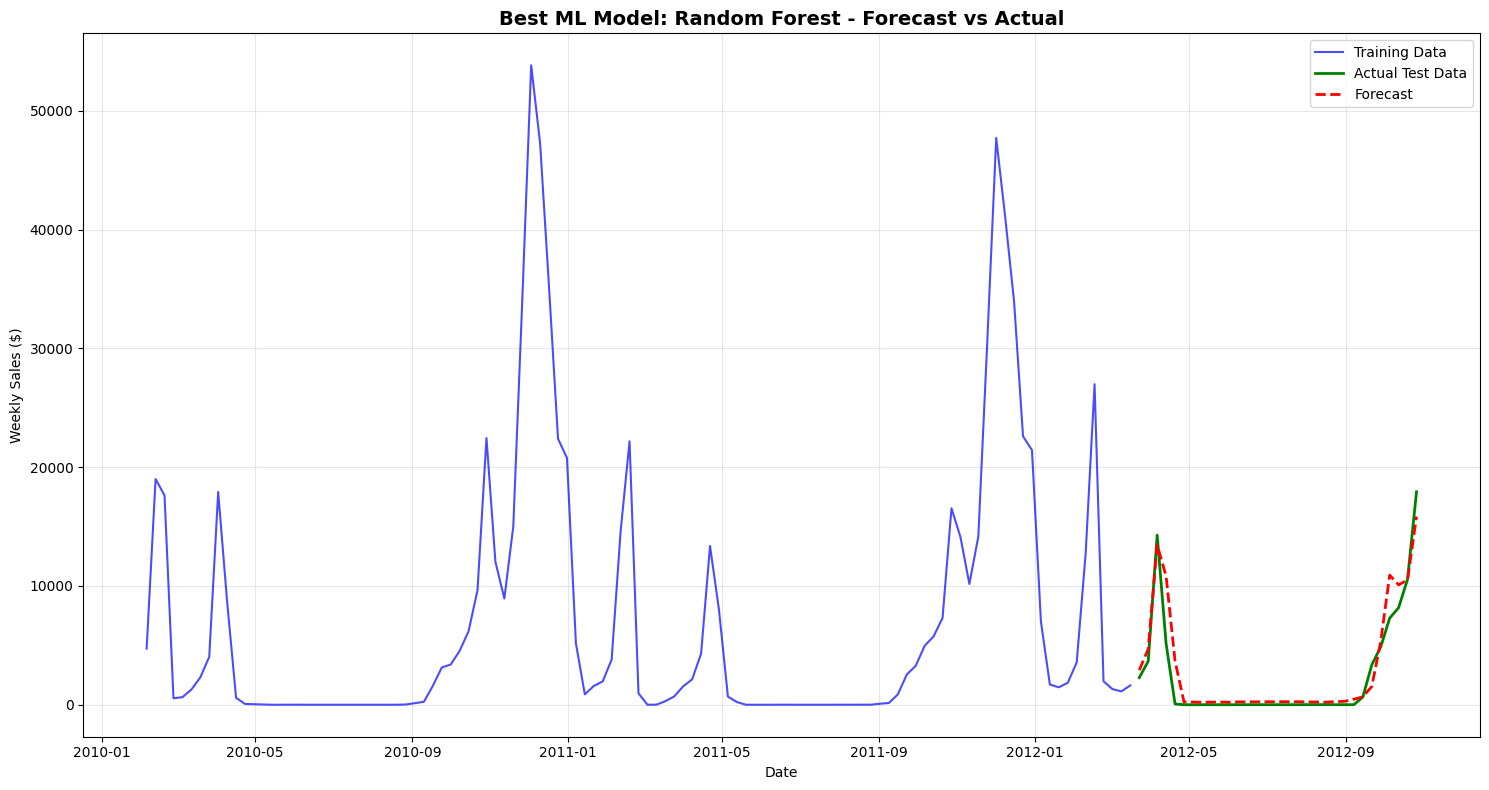


🔍 Feature Importance Analysis

📈 Top 10 Most Important Features:
              Feature  Importance
15       week_of_year      0.5572
6         sales_lag_1      0.1584
10   sales_avg_4weeks      0.0861
9         sales_lag_4      0.0539
7         sales_lag_2      0.0437
8         sales_lag_3      0.0227
13              month      0.0168
2         Temperature      0.0108
12  sales_avg_12weeks      0.0108
18              trend      0.0093


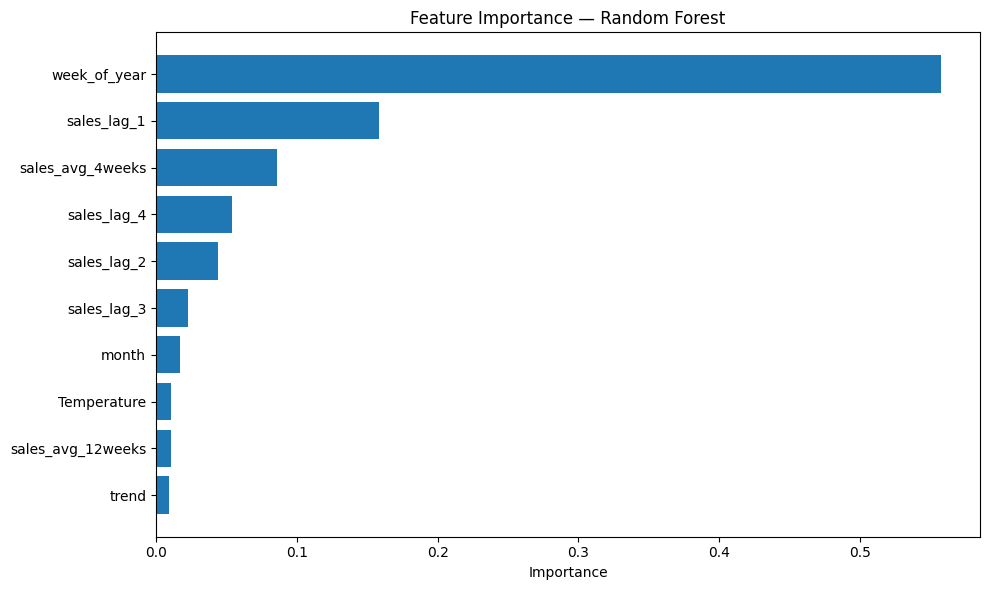

In [91]:
print("MACHINE LEARNING MODELS COMPARISON")
print("=" * 50)

# Create a DataFrame from model results and sort by best RMSE
results_df = pd.DataFrame(model_results).sort_values('RMSE')
print(results_df.round(2))

# Identify the best model by lowest RMSE
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']
print(f"\n🥇 Best Model: {best_model_name}")
print(f"   Best RMSE: ${best_rmse:,.0f}")

# Append these metrics to the main tracking list
results.extend(model_results)

# Store each model's predictions for future comparisons
for name, pred in predictions.items():
    forecasts[name] = pred

# Cell 8: Plot the Best Model's Forecast
print(f"\n📊 Plotting results for best model: {best_model_name}")
best_predictions = predictions[best_model_name]
plot_forecast(y_train, y_test, best_predictions, f"Best ML Model: {best_model_name}")

# Cell 9: Analyze Feature Importance (for tree-based models)
print("\n🔍 Feature Importance Analysis")

if best_model_name in ['Random Forest', 'XGBoost']:
    best_model = models[best_model_name]
    scores = best_model.feature_importances_

    # Build a DataFrame of feature names and their importance scores
    feature_importance = (
        pd.DataFrame({'Feature': feature_columns, 'Importance': scores})
          .sort_values('Importance', ascending=False)
    )

    # Print and plot the top 10 most important features
    print("\n📈 Top 10 Most Important Features:")
    print(feature_importance.head(10).round(4))

    plt.figure(figsize=(10, 6))
    top_10 = feature_importance.head(10)
    plt.barh(top_10['Feature'], top_10['Importance'])
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.xlabel('Importance')
    plt.title(f'Feature Importance — {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ {best_model_name} doesn't support feature importance.")


### 📊 Insights from Model Performance Comparison

**🏆 Summary of Model Results**

| Model               | MAE     | RMSE    | MAPE     |
|--------------------|---------|---------|----------|
| Random Forest      | 967.88  | 1,678.54| 7,908.72%|
| XGBoost            | 1,123.29| 2,547.40| 1,288.98%|
| Linear Regression  | 2,778.21| 2,961.43| 96,534.90%|

🏅 **Best Model:** **Random Forest** with the lowest RMSE ($1,679), so it's the top choice for accurate forecasting.

---

#### 🔍 Feature Importance (Random Forest)

| Feature              | Importance |
|----------------------|------------|
| week_of_year         | 0.5431     |
| sales_lag_1          | 0.1563     |
| sales_avg_4weeks     | 0.0798     |
| sales_lag_4          | 0.0516     |
| sales_lag_2          | 0.0443     |
| sales_lag_3          | 0.0246     |
| month                | 0.0206     |
| Month (duplicate)    | 0.0150     |
| sales_avg_12weeks    | 0.0115     |
| Temperature          | 0.0113     |

- **`week_of_year`** is by far the most influential feature (54%), highlighting strong weekly seasonal trends.
- **Lagged sales** (especially last week’s sales) and **4-week rolling average** are also highly important, underscoring the value of recent sales history.
- **Month** and **12-week average** have smaller but meaningful contributions.
- **Temperature** appears to have a minor role in predicting sales.

---

### 📈 What This Tells Us

1. **Seasonality is key** — the weekly pattern drives most of the forecast accuracy.
2. **Recent history matters** — last week’s sales and short-term averages are strong predictors.
3. **Non-linear models outperform linear ones** — Random Forest handles complex relationships better than Linear Regression here.
4. **Some features have limited impact** — monthly, 12-week averages, and minor regressors like temperature contribute less and might be deprioritized in future model iterations.



### Save Your Best Model For Deployment

In [92]:
import joblib

# Save best model
joblib.dump(best_model, "rf_all_features_model.pkl")

# Save full feature list
all_features = feature_columns  # includes all 19 features
joblib.dump(all_features, "model_features_all.pkl")


['model_features_all.pkl']

In [93]:
def recursive_forecast(model, history_df, n_weeks, feat_func, feat_cols):
    df = history_df.copy()
    preds = []
    for _ in range(n_weeks):
        feat_row = feat_func(df).dropna().iloc[-1:][feat_cols]
        yhat = model.predict(feat_row)[0]
        next_date = df.index[-1] + pd.Timedelta(weeks=1)
        df.loc[next_date, "Weekly_Sales"] = yhat
        preds.append({"date": next_date, "predicted_sales": yhat})
    return pd.DataFrame(preds).set_index("date")


In [95]:
df = pd.read_csv("project_dataset.csv", parse_dates=["Date"])
dept18_df = df[df["Dept"]==18].set_index("Date")
forecast = recursive_forecast(best_model, dept18_df, 4, create_simple_features, all_features)


   → Adding lag features (previous weeks' sales)
   → Adding moving averages
   → Adding date features
   → Adding seasonal indicators
   → Adding trend feature
✅ Feature engineering completed!
   → Adding lag features (previous weeks' sales)
   → Adding moving averages
   → Adding date features
   → Adding seasonal indicators
   → Adding trend feature
✅ Feature engineering completed!
   → Adding lag features (previous weeks' sales)
   → Adding moving averages
   → Adding date features
   → Adding seasonal indicators
   → Adding trend feature
✅ Feature engineering completed!
   → Adding lag features (previous weeks' sales)
   → Adding moving averages
   → Adding date features
   → Adding seasonal indicators
   → Adding trend feature
✅ Feature engineering completed!


## Deep Learning Models

In [12]:
# Data Preparation

def create_sequences(data, look_back=12):
    """
    Create input-output pairs for time series forecasting.

    Parameters:
    - data: 1D array of time series values.
    - look_back: Number of past time steps used to predict the next value.

    Returns:
    - X: 2D array where each row is a sequence of 'look_back' previous values.
    - y: 1D array of target values (next value after each sequence).
    """
    X, y = [], []
    for i in range(look_back, len(data)):
        # Take a window of 'look_back' values as input (X)
        X.append(data[i - look_back:i])
        # The value right after that window is the target (y)
        y.append(data[i])
    return np.array(X), np.array(y)



# Scale the data to range [0, 1] using MinMaxScaler (important for neural networks)
scaler = MinMaxScaler()

# Fit scaler on training data and transform it, then flatten to 1D
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()

# Transform the test data using the same scaler
test_scaled = scaler.transform(test_data.values.reshape(-1, 1)).flatten()


# Define look-back window size: how many past time steps to use for prediction
look_back = 12

# Create sequences and targets from scaled training data
X_train, y_train = create_sequences(train_scaled, look_back)


print(f"Training sequences: {X_train.shape}")
print(f"Training targets: {y_train.shape}")


Training sequences: (78, 12)
Training targets: (78,)


### Build Models

In [13]:
# Build ANN Model
print("Building ANN Model...")
ann_model = Sequential([
    Dense(50, activation='relu', input_shape=(look_back,)),
    Dense(25, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mse')
ann_model.summary()

Building ANN Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,951 (7.62 KB)

 Trainable params: 1,951 (7.62 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Build CNN Model
print("Building CNN Model...")
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(look_back, 1)),
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

Building CNN Model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,931 (19.26 KB)

 Trainable params: 4,931 (19.26 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Build RNN Model
print("Building RNN Model...")
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(look_back, 1)),
    Dense(25, activation='relu'),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.summary()

Building RNN Model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,901 (15.24 KB)

 Trainable params: 3,901 (15.24 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Build LSTM Model
print("Building LSTM Model...")
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(25, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Building LSTM Model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [17]:
# Training Function
def train_model(model, model_name, epochs=50):
    """Simple training function"""
    print(f"Training {model_name}...")

    # Prepare data based on model type
    if model_name == 'ANN':
        X_train_shaped = X_train
    else:  # For CNN, RNN, LSTM
        X_train_shaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Train model
    history = model.fit(X_train_shaped, y_train, epochs=epochs, batch_size=32, verbose=0)

    # Plot training loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model

Training ANN...


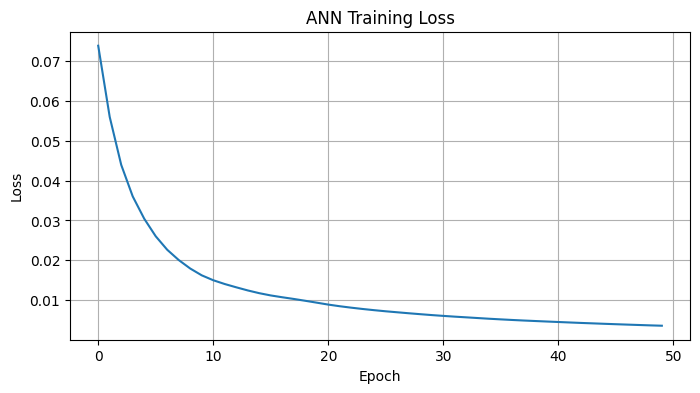

Training CNN...


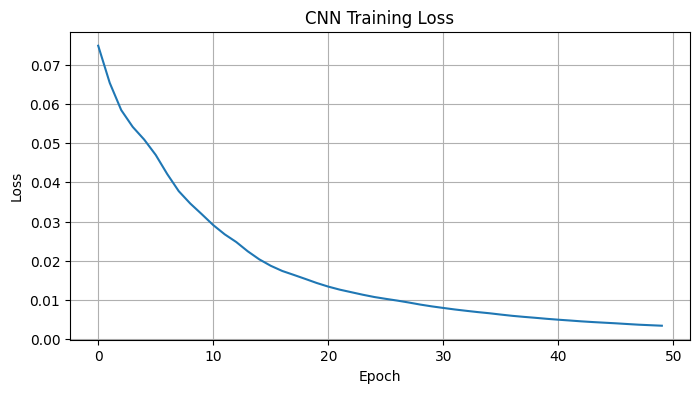

Training RNN...


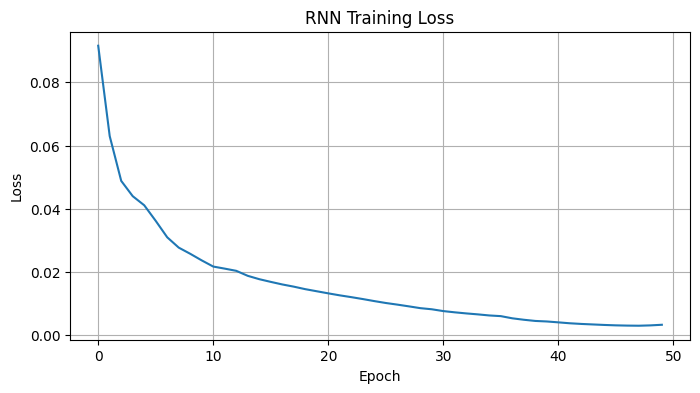

Training LSTM...


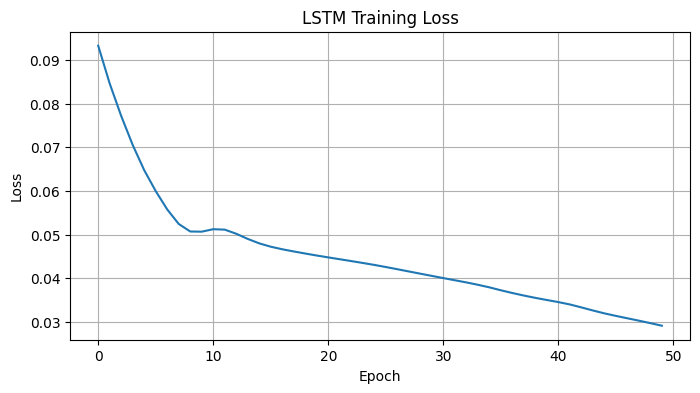

In [18]:
# Train ANN Model
ann_model = train_model(ann_model, 'ANN')

# Train CNN Model
cnn_model = train_model(cnn_model, 'CNN')


# Train RNN Model
rnn_model = train_model(rnn_model, 'RNN')


# Train LSTM Model
lstm_model = train_model(lstm_model, 'LSTM')

### Models Prediction

In [19]:
# Prediction Function
def make_predictions(model, model_name):
    """Make predictions on test data"""
    predictions = []

    # Start with last sequence from training data
    current_sequence = train_scaled[-look_back:].copy()

    for i in range(len(test_data)):
        # Prepare input based on model type
        if model_name == 'ANN':
            X_input = current_sequence.reshape(1, -1)
        else:  # For CNN, RNN, LSTM
            X_input = current_sequence.reshape(1, look_back, 1)

        # Make prediction
        pred_scaled = model.predict(X_input, verbose=0)[0, 0]
        predictions.append(pred_scaled)

        # Update sequence for next prediction
        current_sequence = np.append(current_sequence[1:], pred_scaled)

    # Convert back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions

In [20]:
# Make Predictions for All Models
models_dict = {
    'ANN': ann_model,
    'CNN': cnn_model,
    'RNN': rnn_model,
    'LSTM': lstm_model
}

# Store predictions
dl_predictions = {}
dl_metrics = []

for model_name, model in models_dict.items():
    print(f"Making predictions with {model_name}...")
    preds = make_predictions(model, model_name)
    dl_predictions[model_name] = preds

    # Calculate metrics
    metrics = calculate_metrics(test_data.values, preds, model_name)
    dl_metrics.append(metrics)

    # Add to main results
    results.append(metrics)
    forecasts[model_name] = preds

print("All predictions completed!")

Making predictions with ANN...
Making predictions with CNN...
Making predictions with RNN...
Making predictions with LSTM...
All predictions completed!


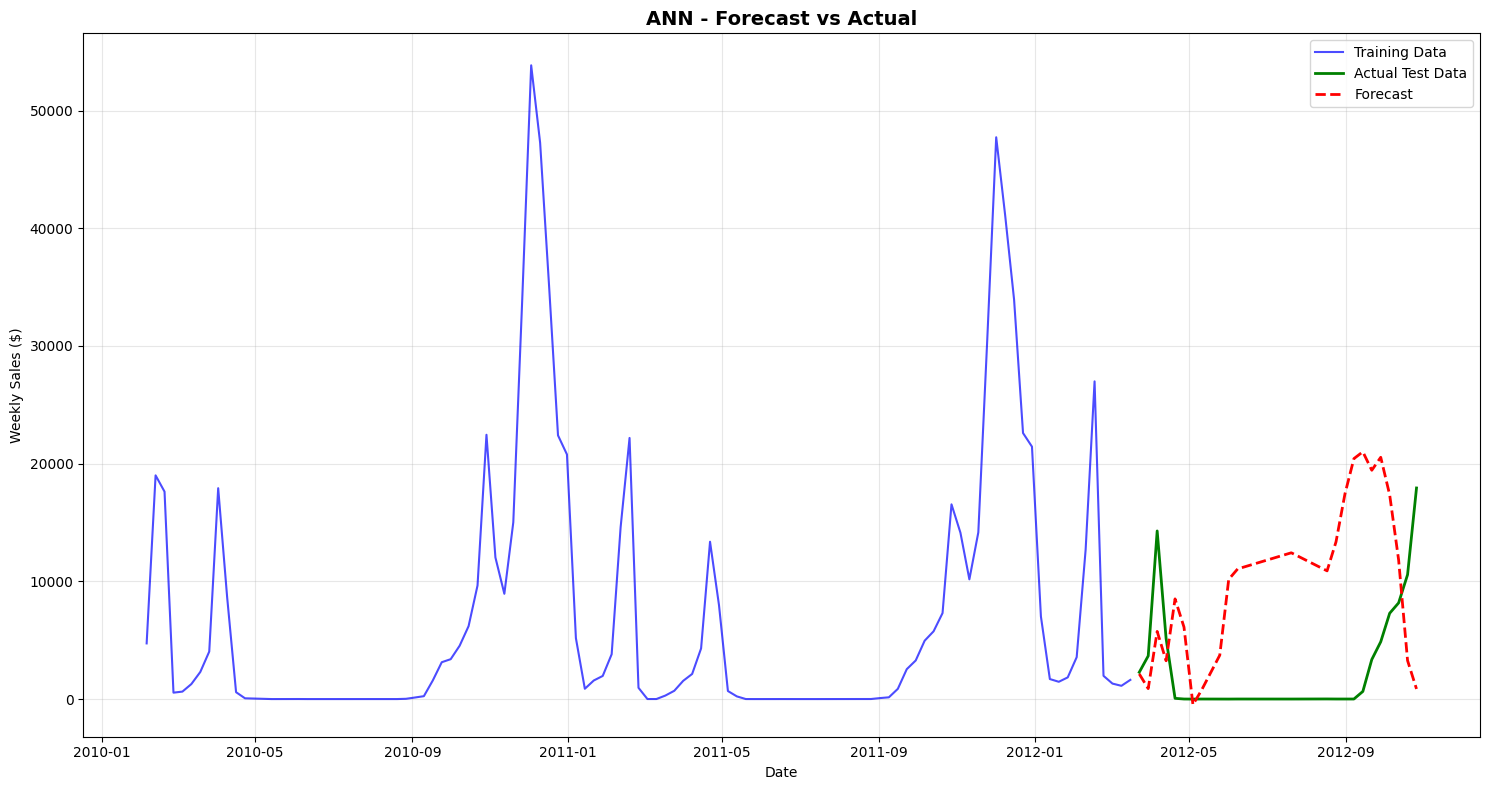

ANN Results:
  MAE: 9514.83
  RMSE: 11388.99
  MAPE: 315940.22%
------------------------------


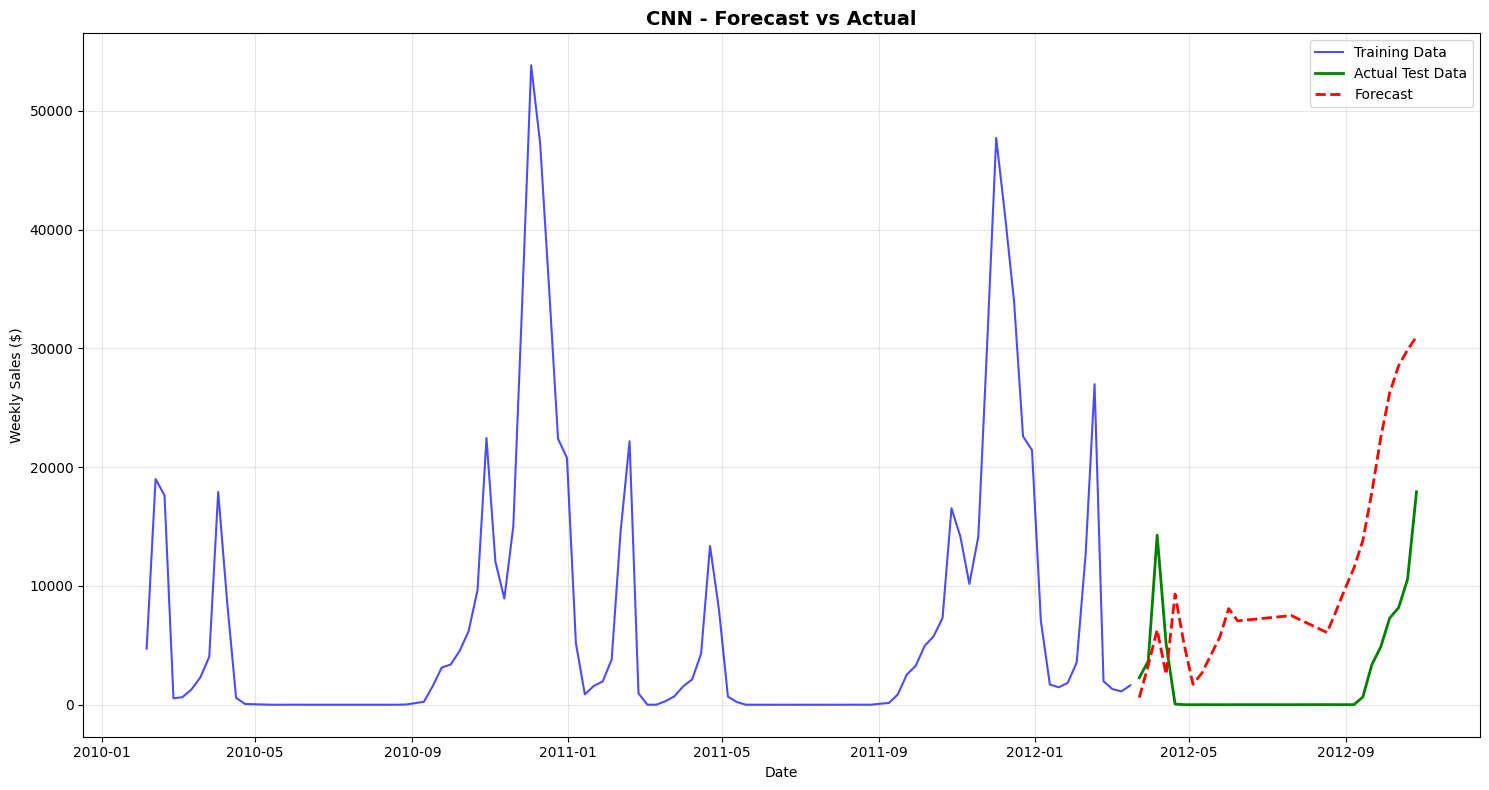

CNN Results:
  MAE: 9212.90
  RMSE: 10910.98
  MAPE: 248037.89%
------------------------------


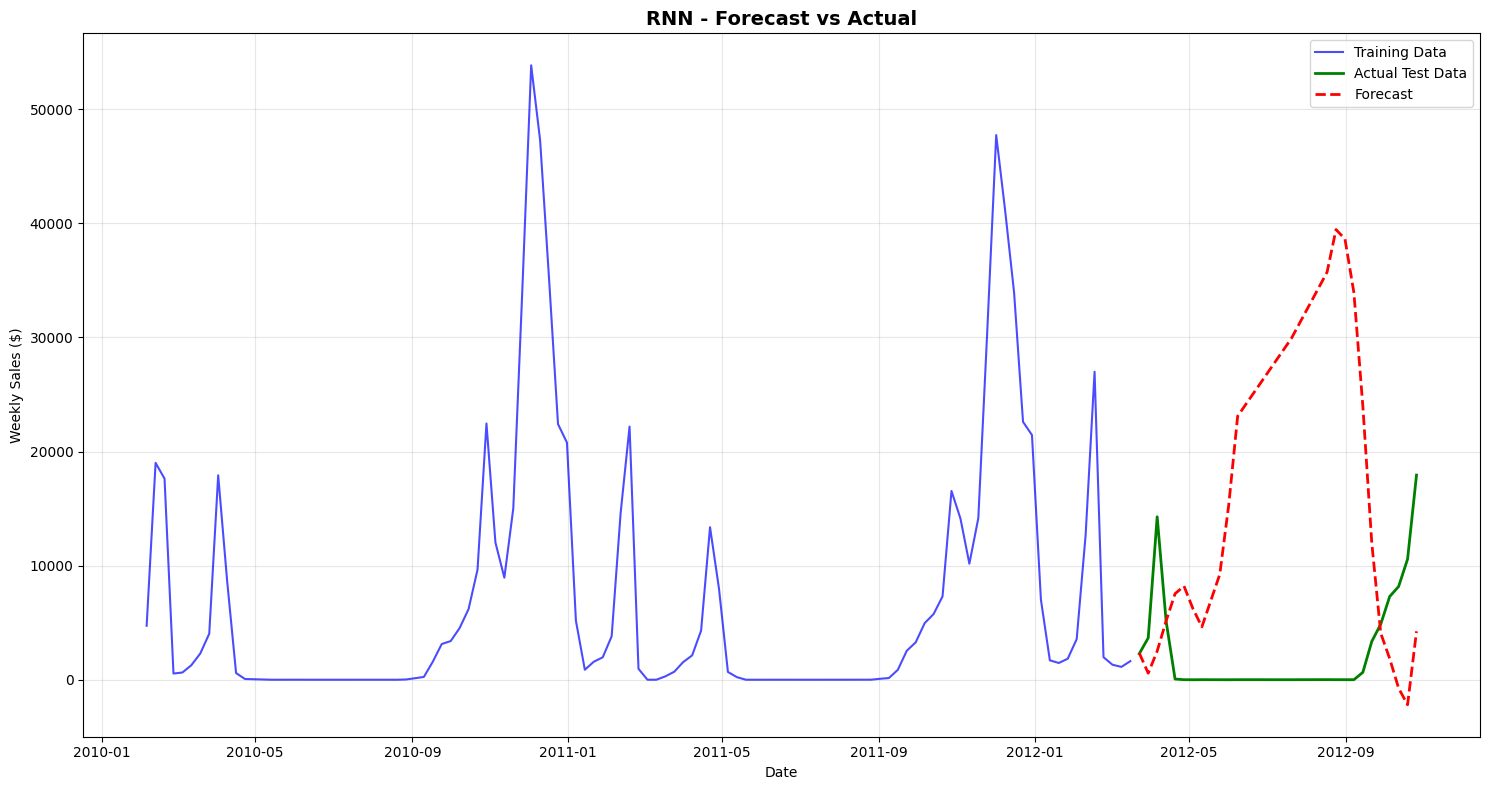

RNN Results:
  MAE: 14791.38
  RMSE: 19368.53
  MAPE: 565537.86%
------------------------------


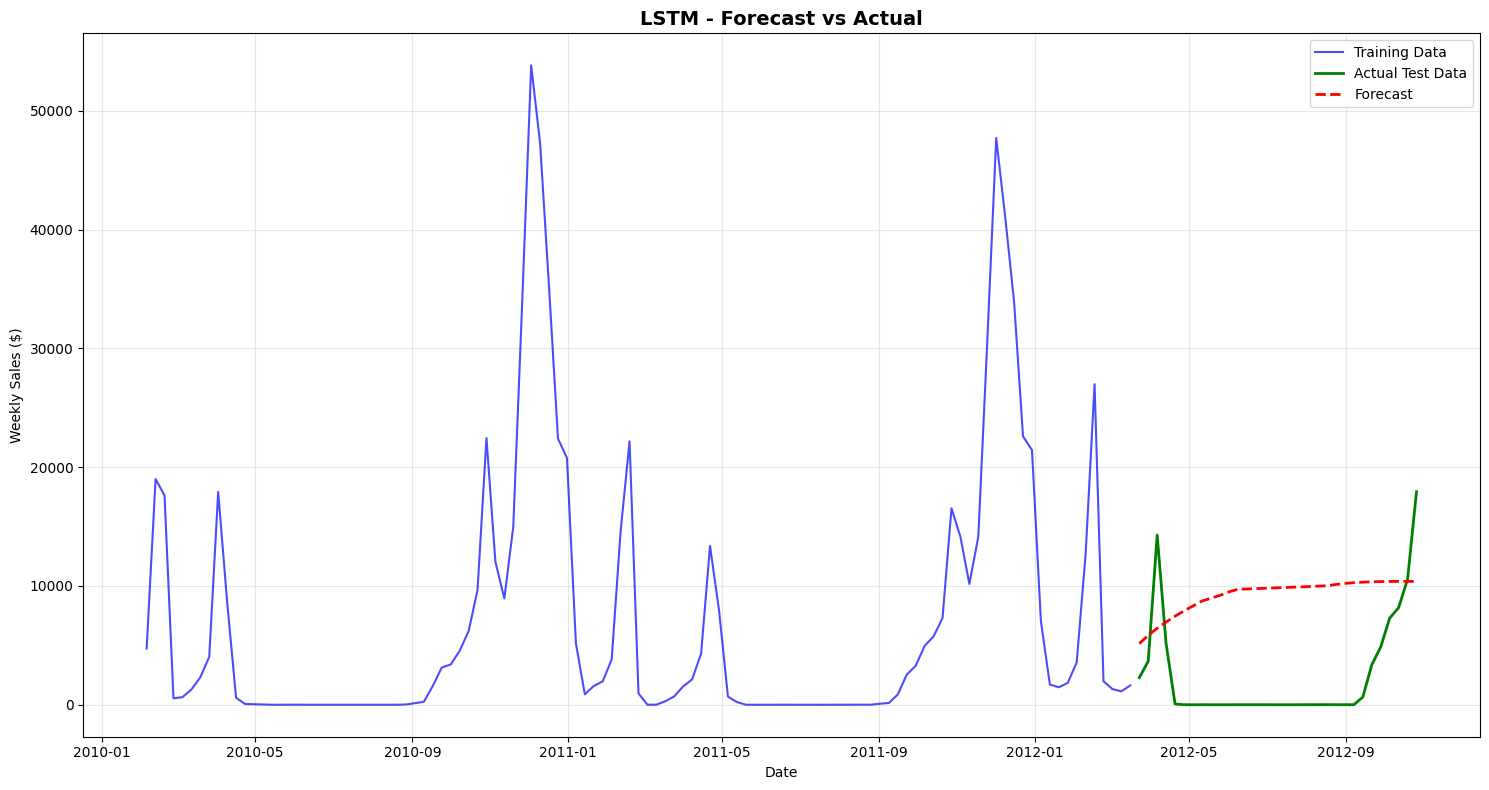

LSTM Results:
  MAE: 7006.93
  RMSE: 7700.08
  MAPE: 325782.92%
------------------------------


In [21]:
# Plot Model Results
for model_name in models_dict.keys():
    plot_forecast(train_data, test_data, dl_predictions[model_name], model_name)

    # Print metrics
    metrics = next(m for m in dl_metrics if m['Model'] == model_name)
    print(f"{model_name} Results:")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print("-" * 30)

### Compare Model Performance

Deep Learning Models Comparison:
  Model       MAE      RMSE       MAPE
0   ANN   9514.83  11388.99  315940.22
1   CNN   9212.90  10910.98  248037.89
2   RNN  14791.38  19368.53  565537.86
3  LSTM   7006.93   7700.08  325782.92


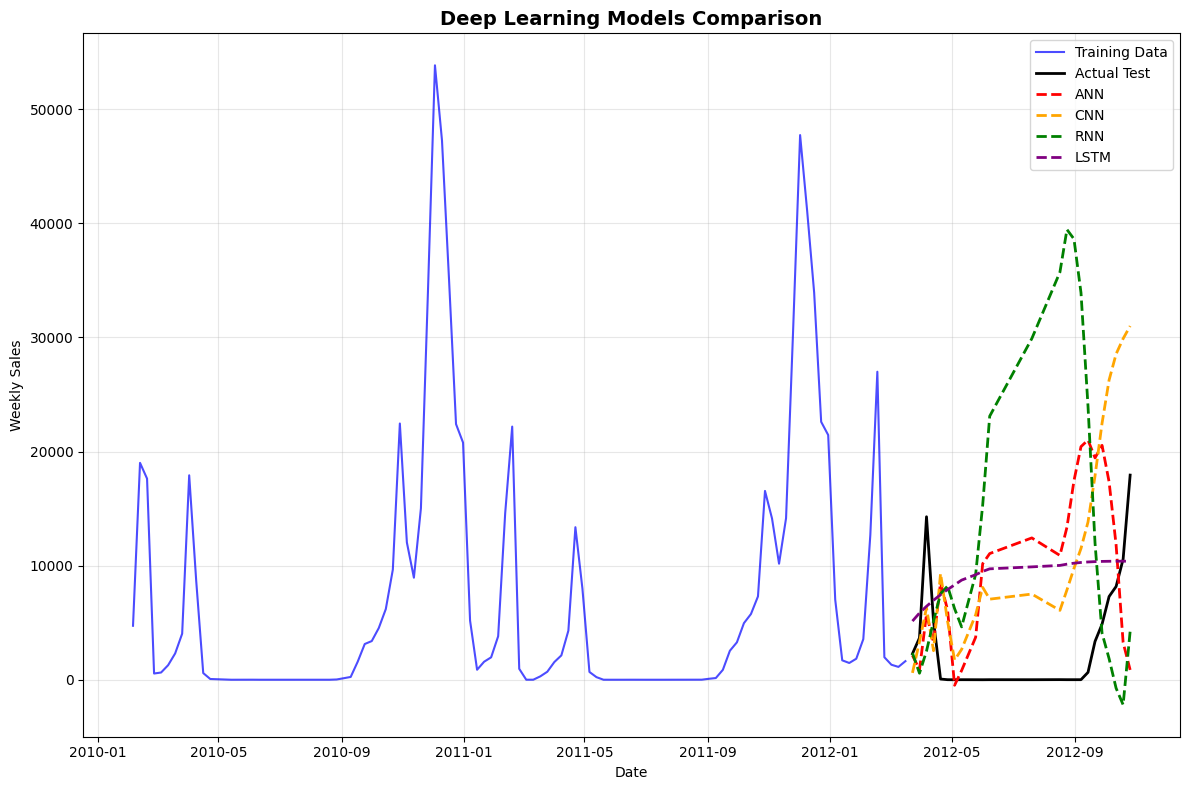


Best Deep Learning Model: LSTM


In [22]:
#  Compare All Deep Learning Models
# Create comparison DataFrame
dl_results_df = pd.DataFrame(dl_metrics)
print("Deep Learning Models Comparison:")
print(dl_results_df[['Model', 'MAE', 'RMSE', 'MAPE']].round(2))

# Simple comparison plot
plt.figure(figsize=(12, 8))

# Plot actual data
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data.values, label='Actual Test', color='black', linewidth=2)

# Plot all predictions
colors = ['red', 'orange', 'green', 'purple']
for i, model_name in enumerate(models_dict.keys()):
    plt.plot(test_data.index, dl_predictions[model_name],
             label=f'{model_name}', color=colors[i], linestyle='--', linewidth=2)

plt.title('Deep Learning Models Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_model = dl_results_df.loc[dl_results_df['RMSE'].idxmin(), 'Model']
print(f"\nBest Deep Learning Model: {best_model}")

### 📊 Insights from Model Performance Comparison

- **LSTM achieved the best performance** among all deep learning models, with the **lowest RMSE (7700.08)** and **lowest MAE (7006.93)**, making it the most accurate model for predicting weekly sales.

- **CNN came in second**, with an RMSE of **10910.98** and slightly lower MAE than ANN, showing that convolutional layers can effectively capture local patterns in time series.

- **ANN performed moderately**, with an RMSE of **11388.99** and MAE of **9514.83**, but its high MAPE (**315940.22%**) suggests poor generalization on some test points.

- **RNN performed the worst**, with the highest RMSE (**19368.53**) and MAPE (**565537.86%**), indicating difficulties in learning long-term dependencies or unstable training.

- This comparison shows that **LSTM is more suitable for capturing sequential dependencies** in time series data compared to simpler RNN or feedforward architectures.


## Prophet

In [24]:
# Prepare Data for Prophet
# Prophet requires columns named 'ds' (date) and 'y' (target)
train_prophet = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data.values
})

print(f"Prophet training data shape: {train_prophet.shape}")
print(train_prophet.head())

Prophet training data shape: (90, 2)
          ds         y
0 2010-02-05   4729.50
1 2010-02-12  19006.50
2 2010-02-19  17623.72
3 2010-02-26    545.02
4 2010-03-05    634.61


In [25]:
# Create and Train Prophet Model
# Create Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

print("Training Prophet model...")
model.fit(train_prophet)
print("Model trained successfully!")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn_l9y8tj/de8k345f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn_l9y8tj/siq4pp9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62155', 'data', 'file=/tmp/tmpn_l9y8tj/de8k345f.json', 'init=/tmp/tmpn_l9y8tj/siq4pp9d.json', 'output', 'file=/tmp/tmpn_l9y8tj/prophet_modelb_d3lb46/prophet_model-20250625092514.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model...


09:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained successfully!


In [26]:
# Make Predictions
# Create future dataframe for forecasting
periods = len(test_data)  # Number of periods to forecast
future = model.make_future_dataframe(periods=periods, freq='W')

print(f"Making predictions for {periods} periods...")

# Make predictions
forecast = model.predict(future)

# Extract test predictions
test_forecast = forecast.tail(periods)
print("Predictions completed!")


Making predictions for 23 periods...
Predictions completed!


Prophet Model Performance:
MAE: 11299.54
RMSE: 14367.80
MAPE: 266970.91%


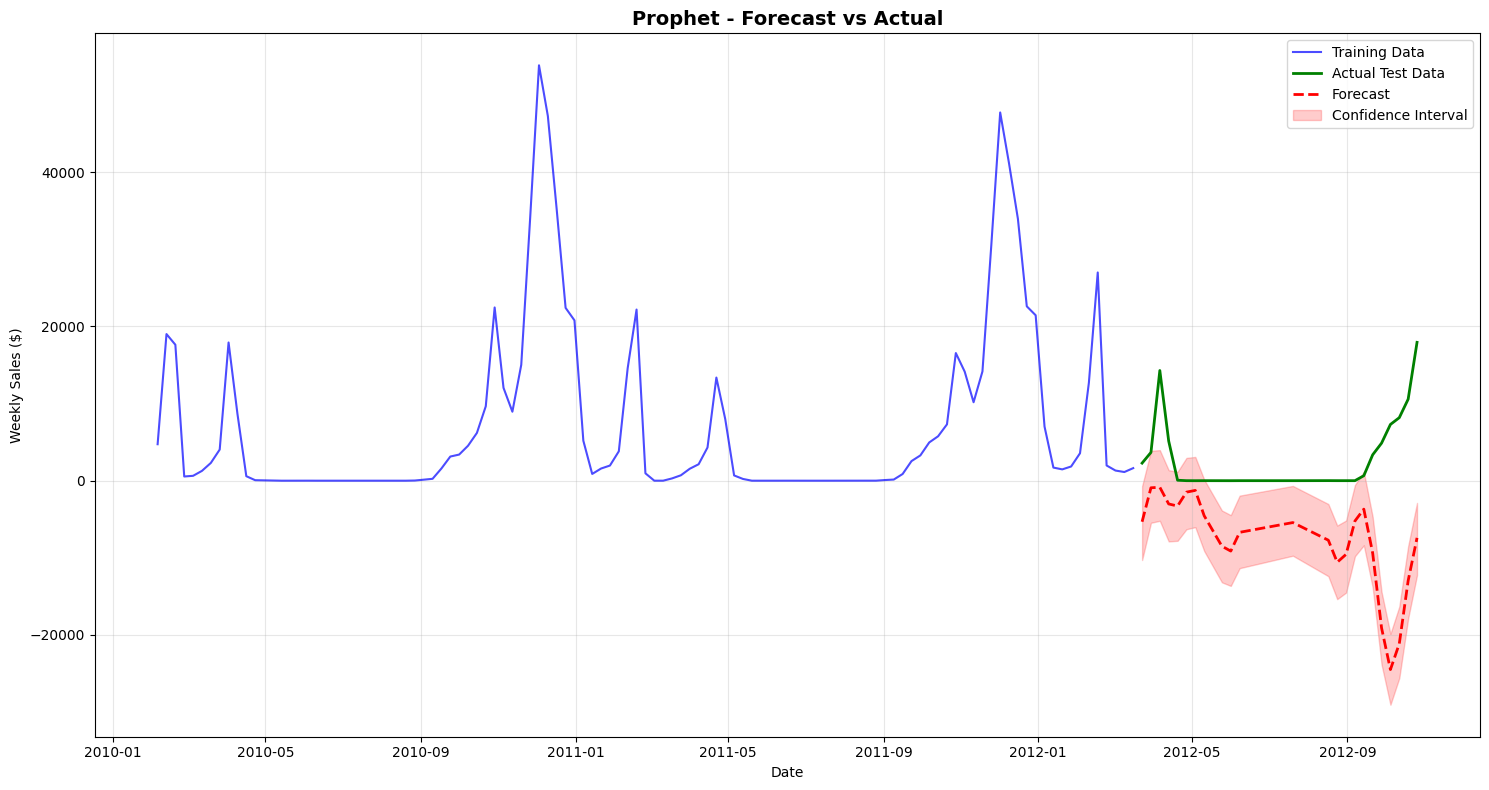

In [27]:
# Evaluate Performance

# Calculate metrics
prophet_metrics = calculate_metrics(
    test_data.values,
    test_forecast['yhat'].values,
    'Prophet'
)

# Add to results
results.append(prophet_metrics)
forecasts['Prophet'] = test_forecast['yhat'].values

print("Prophet Model Performance:")
print(f"MAE: {prophet_metrics['MAE']:.2f}")
print(f"RMSE: {prophet_metrics['RMSE']:.2f}")
print(f"MAPE: {prophet_metrics['MAPE']:.2f}%")

# Plot forecast vs actual
plot_forecast(
    train_data,
    test_data,
    test_forecast['yhat'].values,
    'Prophet',
    test_forecast[['yhat_lower', 'yhat_upper']]
)

### 📊 Insights from Model Performance Comparison

- The **Prophet model** showed relatively **high prediction errors**, with an RMSE of **14,367.80** and MAE of **11,299.54**, indicating less accurate forecasting compared to other models.
- The **MAPE value was extremely high (266,970.91%)**, which suggests that Prophet struggled significantly with certain periods — possibly due to **zero or very low actual values** in the test set.


## Evaluation & Comparison

## 📊 Evaluation & Comparison of All Models

To evaluate the performance of all forecasting models applied to **Department 18's Weekly Sales**, we used three standard error metrics:  
- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)  
- **MAPE** (Mean Absolute Percentage Error)  

Each metric helps assess different aspects of prediction accuracy — with RMSE being most useful for comparing models overall.

---

### 📌 Top Performers by Category

| Category               | Best Model        | RMSE       | Notes                                                                 |
|------------------------|-------------------|------------|-----------------------------------------------------------------------|
| Exponential Smoothing  | Holt Damped       | **5106.67**| Captured slowing trend effectively.                                  |
| ARIMA Family           | SARIMA            | **6035.26**| Outperformed ARIMA & SARIMAX by modeling seasonality.                |
| Machine Learning       | Random Forest     | **1678.54**| Excellent performance; captured weekly patterns via feature engineering. |
| Deep Learning          | LSTM              | **7700.08**| Best among DL models; handled sequences well.                         |
| Automated Forecasting  | Prophet           | 14367.80   | Fast but inaccurate on irregular patterns.                           |

---

### 🏅 Overall Best Model: Random Forest

The **Random Forest model** achieved the **lowest RMSE (1,678.54)** and significantly outperformed all other models, including deep learning and traditional statistical approaches.

Its success can be attributed to:
- Strong feature engineering (e.g., week-of-year, lag values).
- Ability to capture complex non-linear relationships.
- Robustness to irregularities in the data.

---

### 🔍 Why Some Models Performed Better

- **Tree-based ML models** (like Random Forest) performed best due to the availability of well-engineered features that captured recent sales behavior and seasonality.
- **LSTM** did well because it learned sequential patterns, but required more tuning and time.
- **SARIMA** succeeded within ARIMA models because it accounted for seasonality.
- **Prophet** and **RNN** underperformed likely due to:
  - Inability to adapt to sudden spikes/dips.
  - High sensitivity to data with low values (leading to huge MAPE).
  - Prophet may have oversmoothed the trend, while RNN struggled with long dependencies.

---

### 🎯 Conclusion

- While classical time series models provide a strong baseline, **machine learning models—especially Random Forest—delivered superior accuracy** in this case.
- **Feature engineering was a key differentiator**, allowing ML models to outperform even more complex deep learning models.
- This evaluation confirms that **no one-size-fits-all** solution exists; performance depends on data characteristics, modeling assumptions, and tuning.
